In [6]:
# Importing necessary packages 

import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from collections import Counter
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")

In [11]:
# absolute paths (needs to be made relative or changed according the machine)

geolocation_path     = "G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Data//Geolocation//"
wims_processed_path  = 'G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Data//WIMS_data//WIMS_processed//'

# files

wims_file            = 'Stemlokalen_PS_WS_2023.xlsx'

In [ ]:
# Some parameters

fontname = {'fontname':'Segoe UI'}

In [12]:
# Read WIMS dataset and geodata of the Neterlands

wims_data_all                            = pd.read_excel(wims_processed_path+wims_file)
print("Total number of polling station {}".format(len(wims_data_all)))

Total number of polling station 8669


In [13]:
wims_data_all

id     Gemeente CBS gemeentecode  \
0        1  Aa en Hunze           GM1680   
1        2  Aa en Hunze           GM1680   
2        3  Aa en Hunze           GM1680   
3        4  Aa en Hunze           GM1680   
4        5  Aa en Hunze           GM1680   
...    ...          ...              ...   
8664  8665       Zwolle           GM0193   
8665  8666       Zwolle           GM0193   
8666  8667       Zwolle           GM0193   
8667  8668       Zwolle           GM0193   
8668  8669       Zwolle           GM0193   

                               Naam stembureau Type stembureau  \
0                                Het Markehuis        regulier   
1                 Grand café Hofsteenge, Rolde        regulier   
2               Verzorgingscentrum Hendrik Kok        regulier   
3              Ontmoetingscentrum de Boerhoorn        regulier   
4                          Dorpshuis De Eekhof        regulier   
...                                        ...             ...   
8664              Stemtent naast Eliëzerschool          mobiel   
8665                      School De Schatkamer        regulier   
8666             Woonzorgcentrum Het Zonnehuis        regulier   
8667                       School De Paperclip        regulier   
8668  Kantine CSV28 op sportpark De Verbinding        regulier   

         Gebruiksdoel van het gebouw      Straatnaam Huisnummer Huisletter  \
0                 bijeenkomstfunctie          De Pol          4        NaN   
1     woonfunctie,bijeenkomstfunctie     Hoofdstraat         23        NaN   
2             gezondheidszorgfunctie         De Ziel         86        NaN   
3                 bijeenkomstfunctie          Zuides         50        NaN   
4                 bijeenkomstfunctie        Oal Diek          3        NaN   
...                              ...             ...        ...        ...   
8664                            geen  Broderiestraat        NaN        NaN   
8665                onderwijsfunctie   Wildwalstraat         38        NaN   
8666          gezondheidszorgfunctie   Nijenhuislaan        175        NaN   
8667    woonfunctie,industriefunctie   Oude Wetering        110        NaN   
8668              bijeenkomstfunctie       Sportlaan          4        NaN   

     Postcode   Plaats  Extra adresaanduiding              X              Y  \
0      9444XE  Grolloo                    NaN  241192.995207  550815.999085   
1      9451BA    Rolde                    NaN  239659.141533  556310.005934   
2      9451CT    Rolde                    NaN  240666.439384  555576.893165   
3      9451KD    Rolde                    NaN  239630.281447  555830.147291   
4      9454PL  Ekehaar                    NaN  236814.995246  552429.999103   
...       ...      ...                    ...            ...            ...   
8664   8043PH      NaN  Ingang Broderiestraat  201168.882468  504257.112062   
8665   8043VL   Zwolle                    NaN  200167.892992  504679.183788   
8666   8043WB   Zwolle                    NaN  199734.438452  505535.537770   
8667   8044PA   Zwolle                    NaN  199660.558568  506470.213595   
8668   8044PG   Zwolle                    NaN  199451.394087  506197.803219   

       Latitude  Longitude         Openingstijd        Sluitingstijd  \
0     52.937509   6.669292  2023-03-15T07:30:00  2023-03-15T21:00:00   
1     52.987113   6.647910  2023-03-15T07:30:00  2023-03-15T21:00:00   
2     52.980367   6.662714  2023-03-15T07:30:00  2023-03-15T21:00:00   
3     52.982806   6.647356  2023-03-15T07:30:00  2023-03-15T21:00:00   
4     52.952691   6.604591  2023-03-15T07:30:00  2023-03-15T21:00:00   
...         ...        ...                  ...                  ...   
8664  52.524024   6.067488  2023-03-15T07:30:00  2023-03-15T21:00:00   
8665  52.527901   6.052797  2023-03-15T07:30:00  2023-03-15T21:00:00   
8666  52.535632   6.046525  2023-03-15T07:30:00  2023-03-15T21:00:00   
8667  52.544038   6.045562  2023-03-15T07:30:00  2023-03-15T21:00:00   
8668  52

In [14]:
wims_data_all.columns

Index(['id', 'Gemeente', 'CBS gemeentecode', 'Naam stembureau',
       'Type stembureau', 'Gebruiksdoel van het gebouw', 'Straatnaam',
       'Huisnummer', 'Huisletter', 'Postcode', 'Plaats',
       'Extra adresaanduiding', 'X', 'Y', 'Latitude', 'Longitude',
       'Openingstijd', 'Sluitingstijd',
       'Toegankelijk voor mensen met een lichamelijke beperking'],
      dtype='object')

In [15]:
# exclude mobile and bijzonder polling stations for analysis

wims_data                                = wims_data_all[~wims_data_all['Type stembureau'].isin(['bijzonder', 'mobiel'])]
wims_data                                = wims_data[['Gemeente','CBS gemeentecode','Gebruiksdoel van het gebouw','Naam stembureau']]
print("Total number of regular polling station without mobile and special polling station is {}".format(len(wims_data)))
wims_data                                = wims_data.reset_index(drop=True)

## Remove woon function in case of multiple functions of the building includes woon function
wims_data['Gebruiksdoel van het gebouw'] = wims_data['Gebruiksdoel van het gebouw'].str.replace('woonfunctie,','')

#wims_data.to_excel("D://8491_bzk_meting_stemlokalen//4_output//temp.xlsx")        
normalizing_factor                       = len(wims_data) 

# Cleaning the column 'Gebruiksdoel van het gebouw' and exploding

wims_data['Gebruiksdoel van het gebouw'] = wims_data['Gebruiksdoel van het gebouw'].str.replace('/',',')
wims_data['Gebruiksdoel van het gebouw'] = wims_data['Gebruiksdoel van het gebouw'].str.split(',')
wims_data                                = wims_data.explode('Gebruiksdoel van het gebouw')
wims_data['Gebruiksdoel van het gebouw'] = wims_data['Gebruiksdoel van het gebouw'].str.strip()

Total number of regular polling station without mobile and special polling station is 8480


## Building Function Overview at National Level

In [16]:
# national level
all_functon_national_level             = wims_data['Gebruiksdoel van het gebouw'].values.tolist()
all_functon_national_level             = [fn.strip() for fn in all_functon_national_level]
count_functon_national_level           = Counter(all_functon_national_level)
count_national_level                   = pd.DataFrame.from_dict(count_functon_national_level, orient='index').reset_index()
count_national_level                   = count_national_level.rename(columns={'index':'Gemeente', 0:'Count Funtion'})
count_national_level                   = count_national_level[~count_national_level.Gemeente.isin(['geen','onbekend'])].reset_index(drop=True)
#count_national_level['Percent']        = count_national_level['Count Funtion']*100/count_national_level['Count Funtion'].sum()
count_national_level['Percent']        = count_national_level['Count Funtion']*100/normalizing_factor
count_national_level['Gemeente']       = count_national_level['Gemeente'].str.replace('functie','')
count_national_level['Gemeente']       = count_national_level['Gemeente'] .str.capitalize()
count_national_level                   = count_national_level.sort_values(by= 'Percent', ascending= False)
#count_national_level.to_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Files//nationwide_building_function.xlsx")

In [17]:
count_national_level

Gemeente  Count Funtion    Percent
0        Bijeenkomst           4647  54.799528
3          Onderwijs           1423  16.780660
5              Sport           1293  15.247642
2            Kantoor            877  10.341981
1    Gezondheidszorg            516   6.084906
7               Woon            398   4.693396
4   Overige gebruiks            300   3.537736
8          Industrie            178   2.099057
6             Winkel            135   1.591981
9             Logies             92   1.084906
10               Cel              1   0.011792

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Bijeenkomst'),
  Text(0, 1, 'Onderwijs'),
  Text(0, 2, 'Sport'),
  Text(0, 3, 'Kantoor'),
  Text(0, 4, 'Gezondheidszorg'),
  Text(0, 5, 'Woon'),
  Text(0, 6, 'Overig'),
  Text(0, 7, 'Industrie'),
  Text(0, 8, 'Winkel'),
  Text(0, 9, 'Logies'),
  Text(0, 10, 'Cel')])

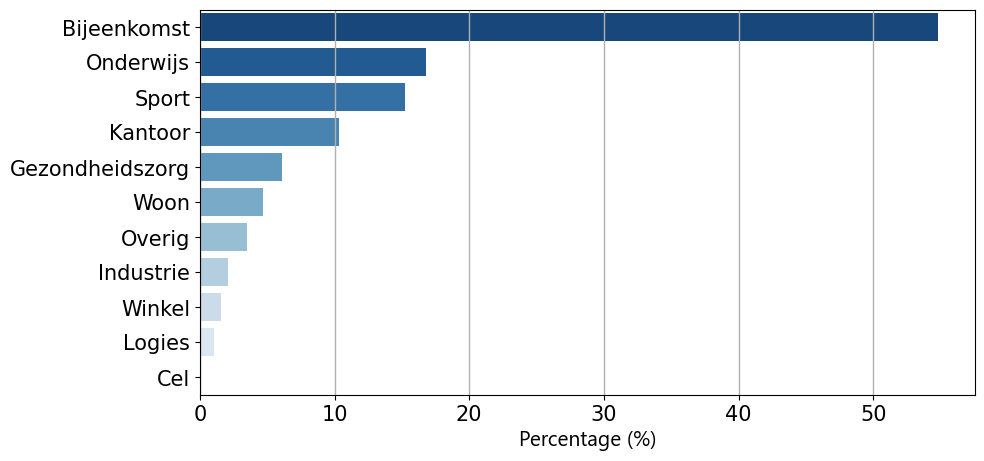

In [18]:
# Make a bar graph
plt.rcParams["figure.figsize"] = [10,5]
count_national_level['Gemeente'].replace('Overige gebruiks','Overig',inplace= True)
sns.barplot(data=count_national_level, x="Percent", y="Gemeente",orient='h',palette= 'Blues_r')
#add plot title
#plt.title('Building functions nationwide', fontsize=16,fontname="Segoe UI")
#add axis labels
plt.xlabel('Percentage (%)',fontsize=15,**fontname)
plt.ylabel('',fontsize=15,**fontname)
plt.grid(axis ='x',linewidth=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
    
#plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//nationwide_building_function.svg", format='svg',bbox_inches = 'tight')
#plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//nationwide_building_function.png", format='png', dpi=500,bbox_inches = 'tight')

In [19]:
# Count the function of building per gemeente

function_count_by_gemeente = wims_data.groupby(['CBS gemeentecode','Gebruiksdoel van het gebouw']).count().reset_index()
function_count_by_gemeente.rename(columns = {'Gemeente':'Count'}, inplace= True)


# Percentage 

start = 0

listgemeente = list(set(wims_data['CBS gemeentecode']))

for gemeente in listgemeente:
    tempgemeente                                = wims_data[wims_data['CBS gemeentecode']==gemeente]
    all_functon                                 = tempgemeente['Gebruiksdoel van het gebouw'].values.tolist()
    all_functon                                 = [fn.strip() for fn in all_functon]
    count_function                              = Counter(all_functon)
    tempcount_all                               = pd.DataFrame.from_dict(count_function, orient='index').reset_index()
    tempcount_all                               = tempcount_all.rename(columns={'index':'Gemeente', 0:'Count Funtion'})
    tempcount_all                               = tempcount_all[~tempcount_all.Gemeente.isin(['geen','onbekend'])].reset_index(drop=True)
    tempcount_all['percent']                    = tempcount_all['Count Funtion']*100/tempcount_all['Count Funtion'].sum()
    tempcount                                   = tempcount_all[['Gemeente','percent']].T
    tempcount_abs                               = tempcount_all[['Gemeente','Count Funtion']].T

    tempcount.columns                           = tempcount.iloc[0]
    tempcount_abs.columns                       = tempcount_abs.iloc[0]
    tempcount                                   = tempcount.iloc[1:, :]
    tempcount_abs                               = tempcount_abs.iloc[1:, :]
    tempcount                                   = tempcount.rename(index={'percent': gemeente })
    tempcount_abs                               = tempcount_abs.rename(index={'Count Funtion': gemeente })
    tempcount['Gemeente']                       = tempcount.index
    tempcount_abs['Gemeente']                   = tempcount_abs.index
    if(start == 0):
        all_gemeente     = tempcount
        start            = start +1
        all_gemeente_abs = tempcount_abs
    else:
        all_gemeente      = pd.concat([all_gemeente,tempcount],axis=0)
        all_gemeente_abs  = pd.concat([all_gemeente_abs,tempcount_abs],axis=0)
        
all_gemeente     = all_gemeente.fillna(0) 
all_gemeente_abs = all_gemeente_abs.fillna(0) 

for col in list(all_gemeente.columns):
    col_new = col.replace('functie','')
    col_new = col_new.capitalize()
    all_gemeente.rename(columns = {col:col_new},inplace= True)
    all_gemeente_abs.rename(columns = {col:col_new},inplace= True)

#all_gemeente.to_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Files//Municipality_level_building_function.xlsx")    

In [20]:
#geodata_url = "https://service.pdok.nl/kadaster/bestuurlijkegebieden/wfs/v1_0?request=GetFeature&service=WFS&version=1.1.0&outputFormat=application%2Fjson%3B%20subtype%3Dgeojson&typeName=bestuurlijkegebieden:Gemeentegebied"
#gemeentegrenzen = gpd.read_file(geodata_url)
gemeentegrenzen = gpd.read_file("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Data//Geolocation//gemeente 2023.gml")
(gemeentegrenzen.shape)

(342, 7)

In [21]:
#all_gemeente_abs.drop(columns= ['Gemeente'],inplace = True)

gemeente_boundaries = pd.merge(gemeentegrenzen, all_gemeente,
                               left_on = "statcode", 
                               right_on = "Gemeente")
gemeente_boundaries.rename(columns = {'Overige gebruiks':'Overige'}, inplace= True)

In [22]:
gemeente_boundaries['Bijeenkomst']

0      50.819672
1      23.170732
2      45.833333
3      40.000000
4      40.000000
         ...    
337    65.625000
338    35.135135
339    58.208955
340    45.454545
341    29.411765
Name: Bijeenkomst, Length: 342, dtype: float64

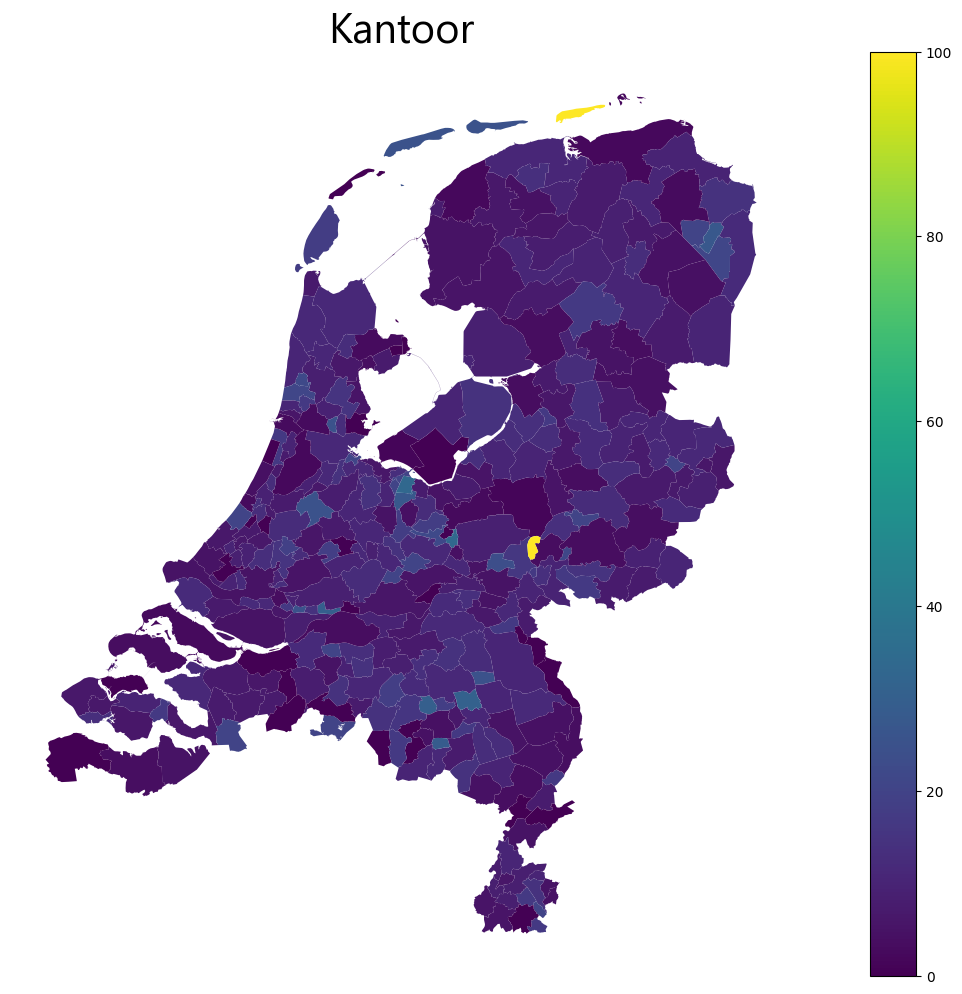

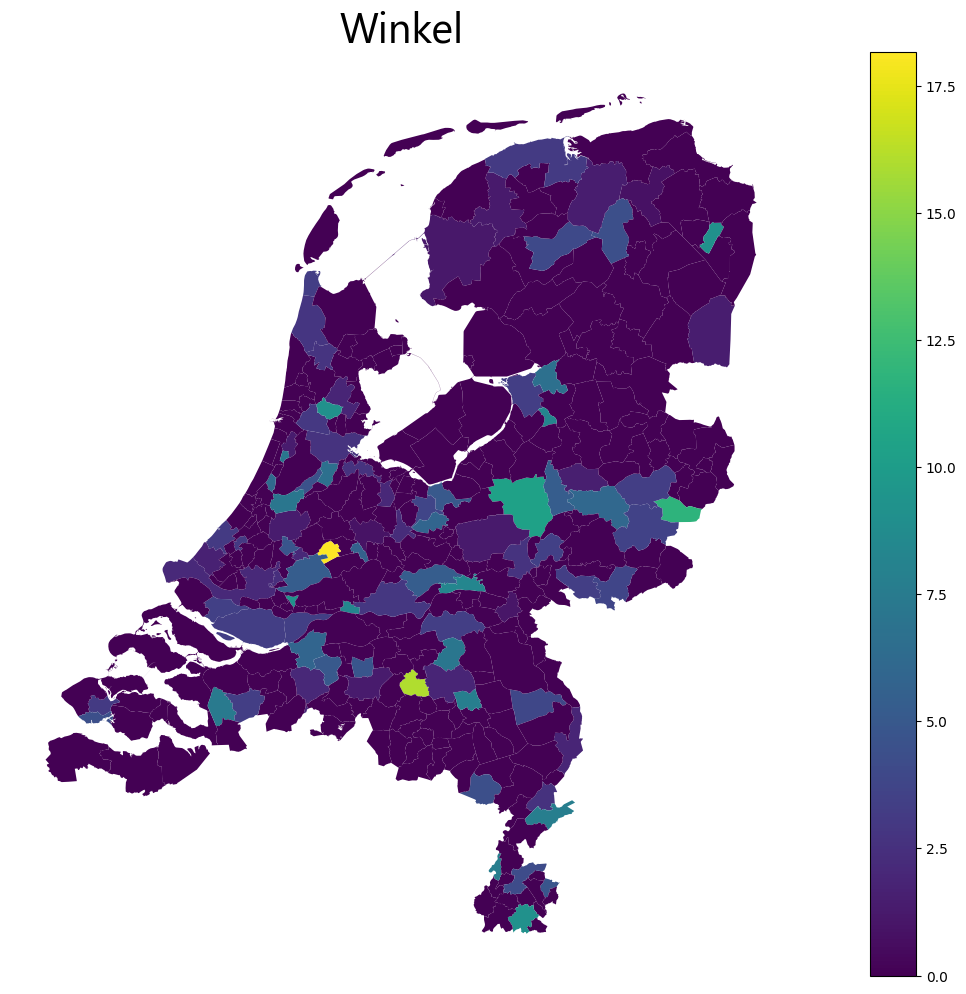

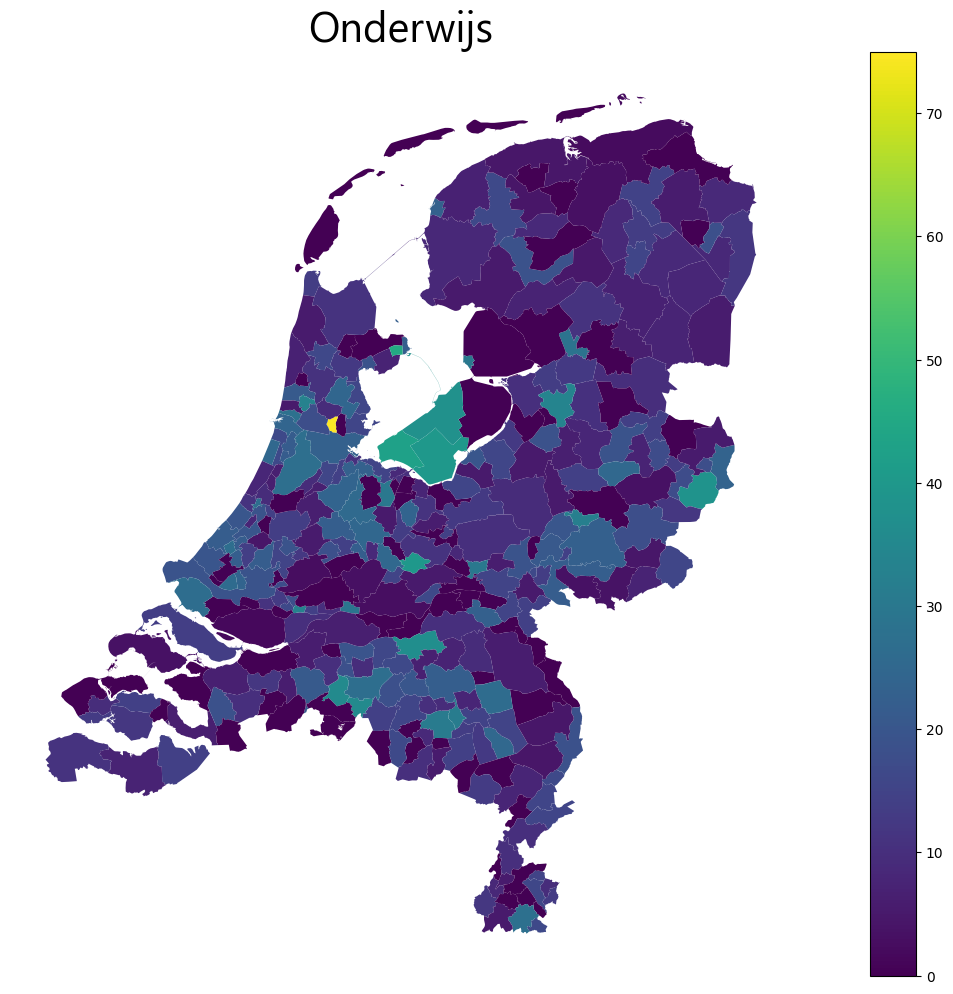

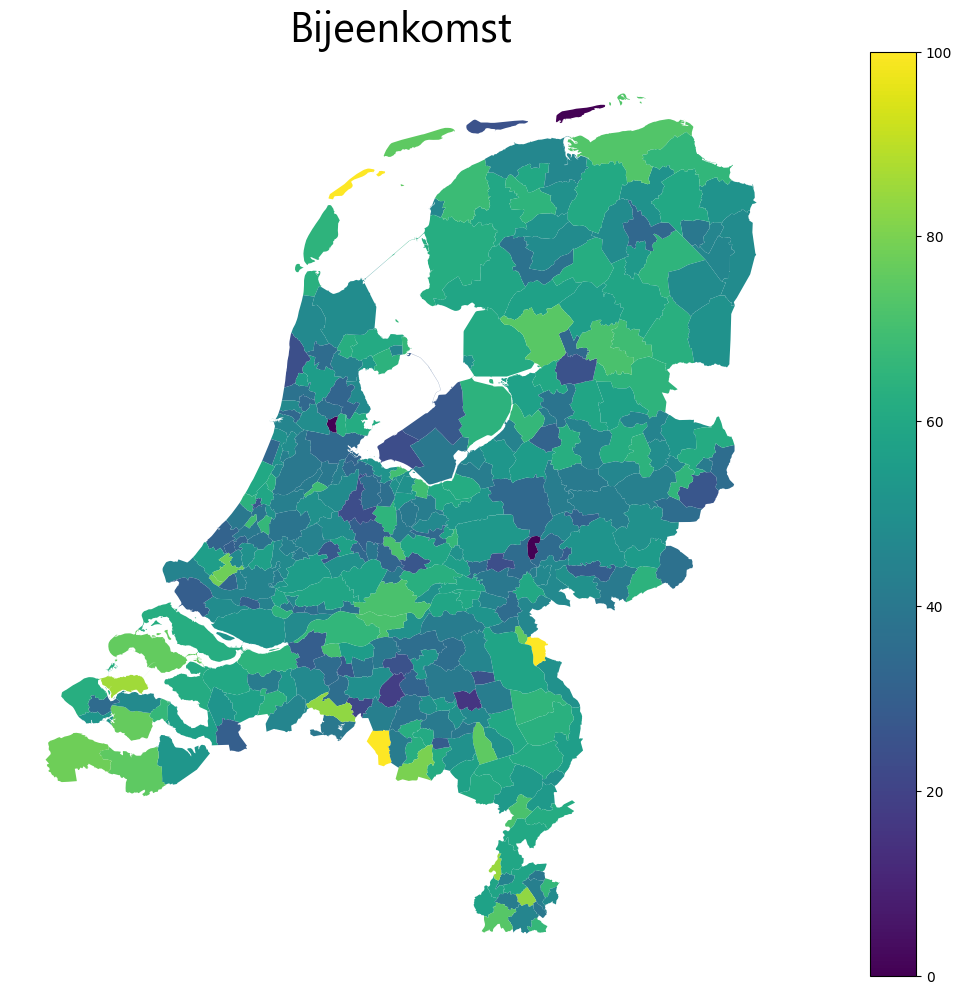

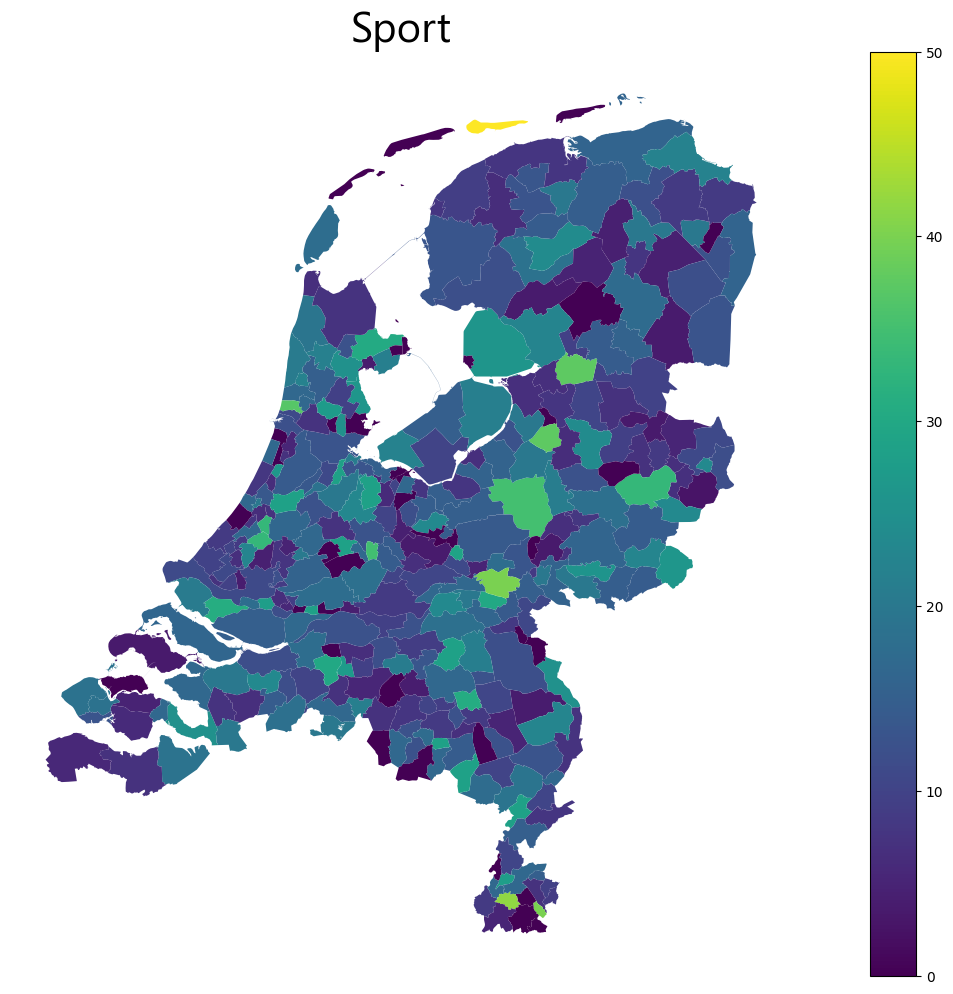

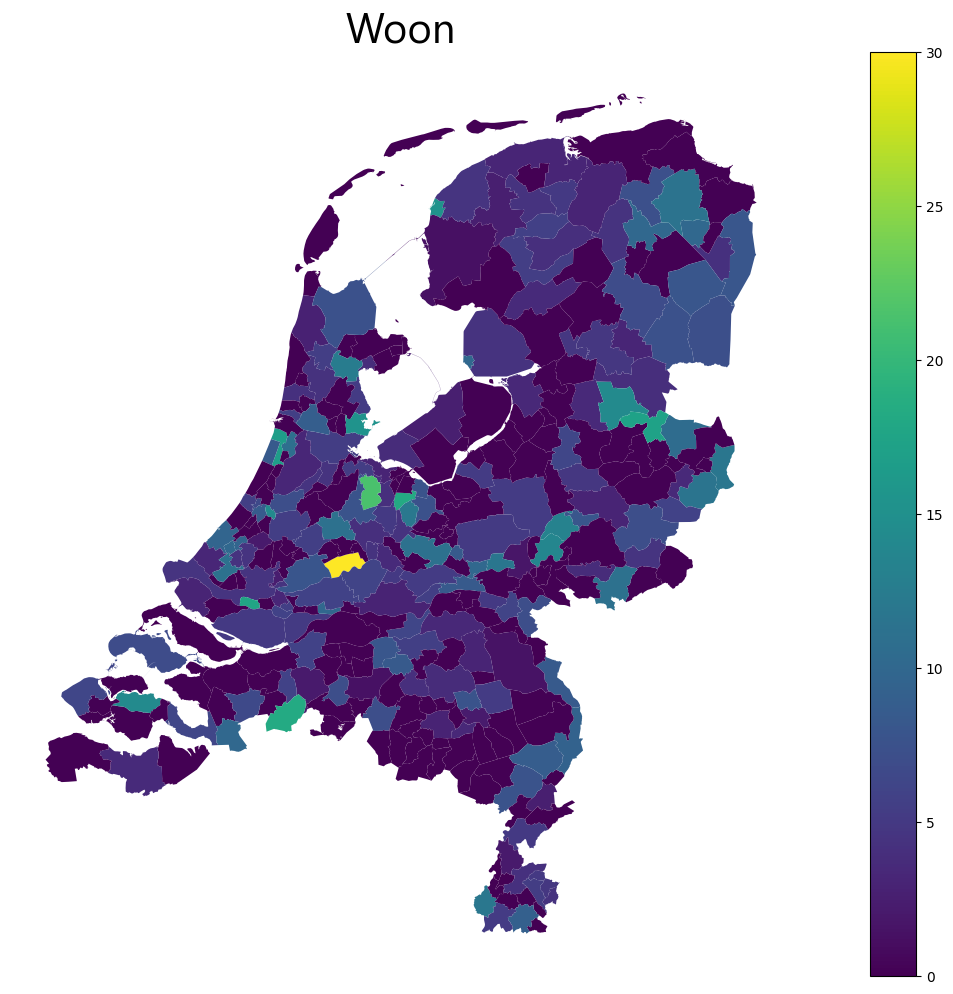

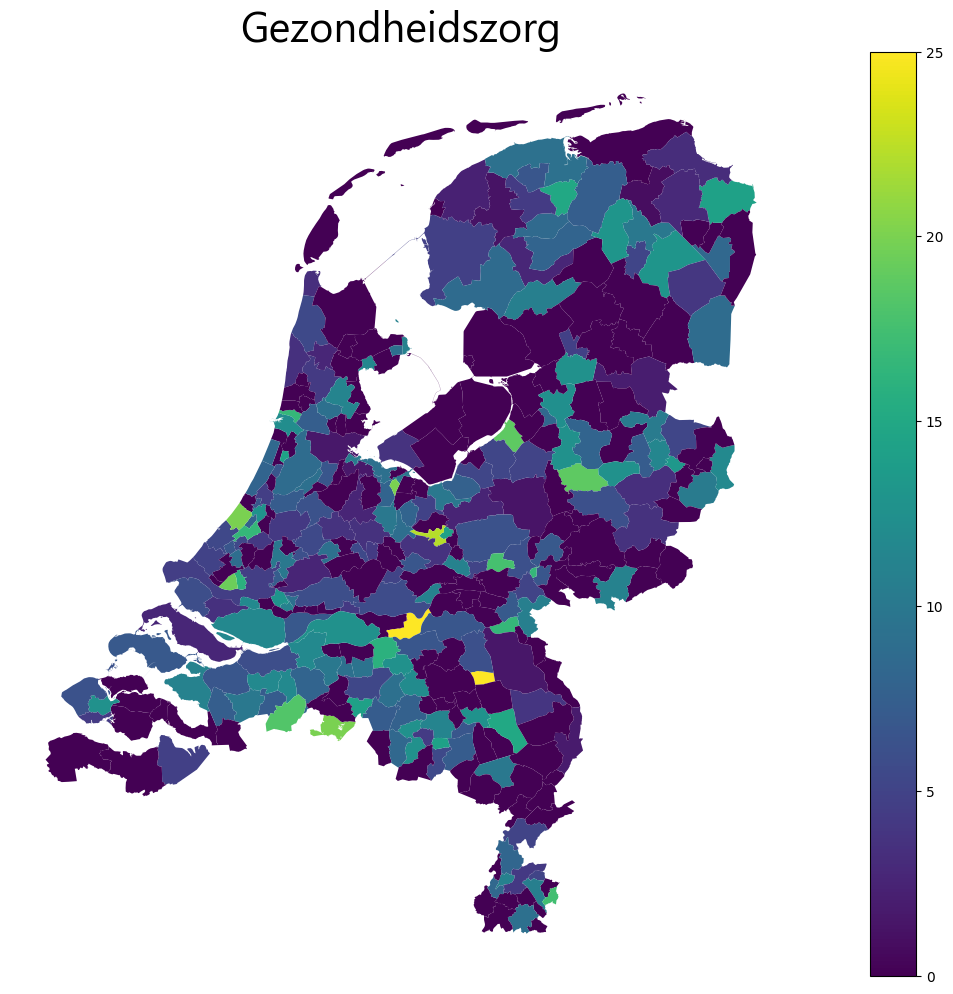

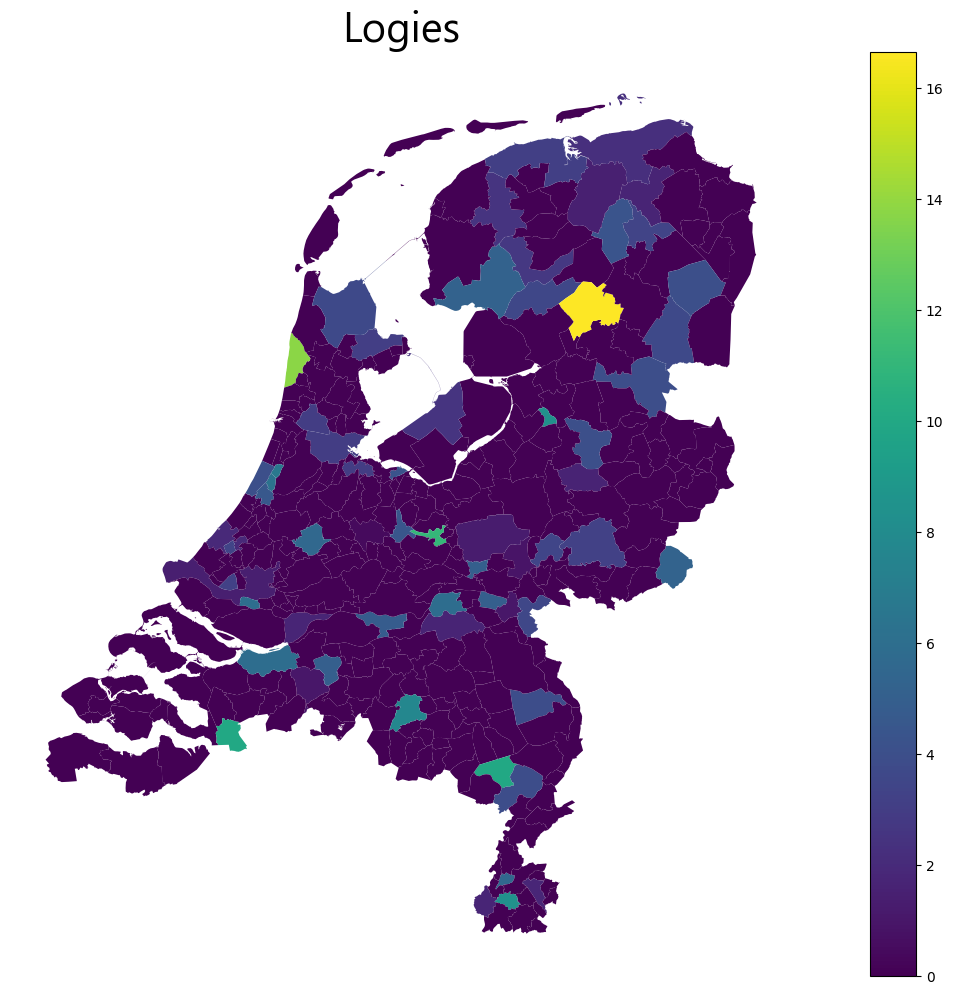

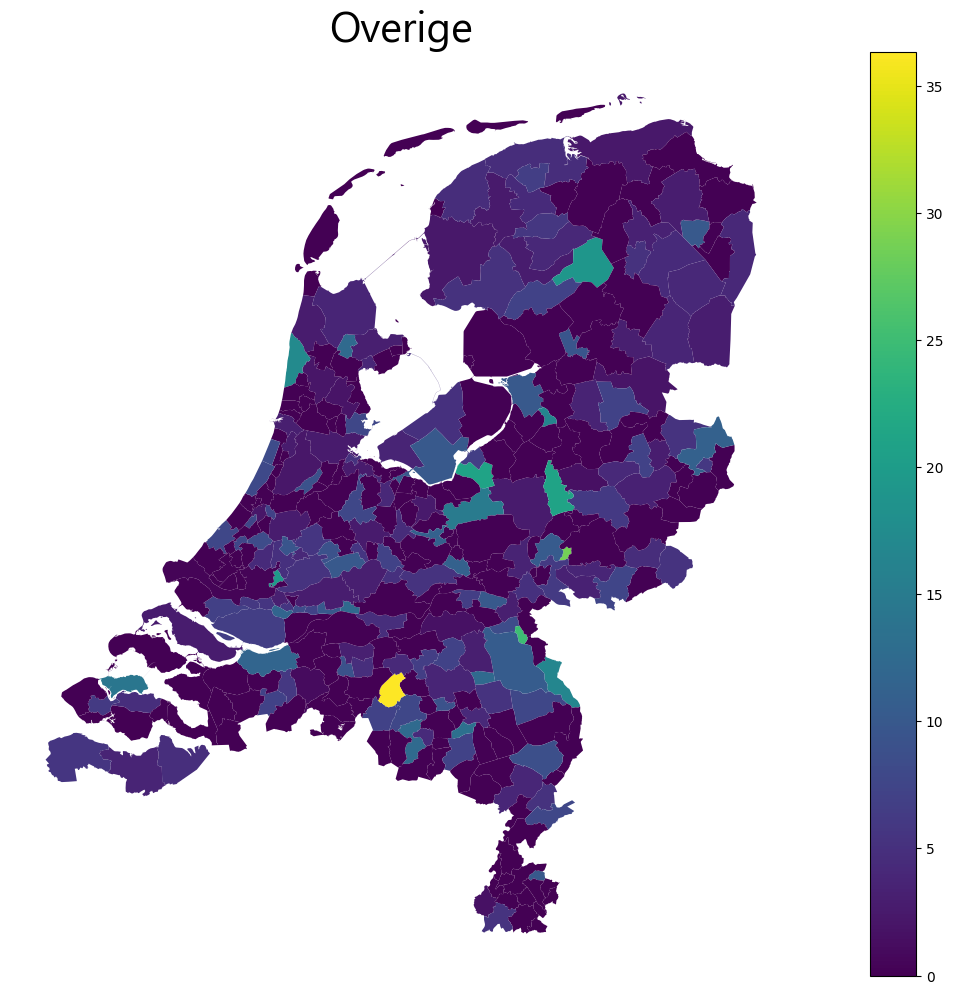

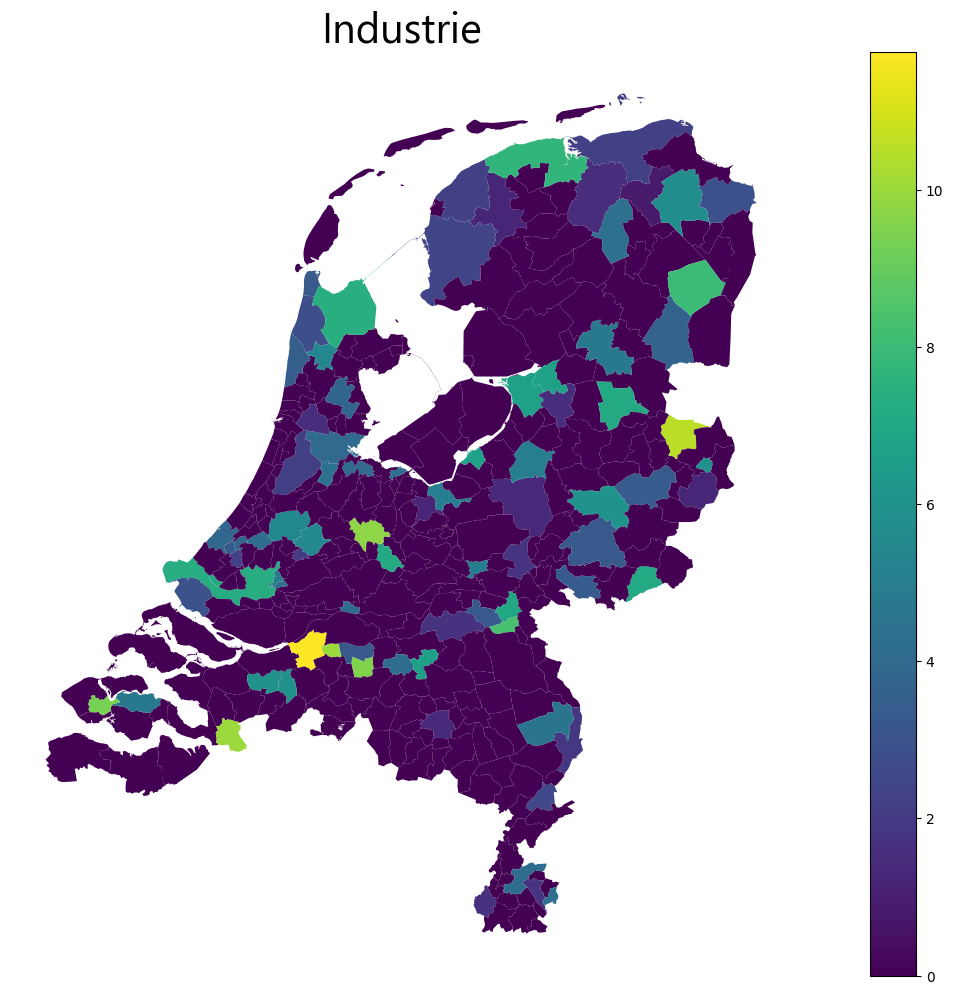

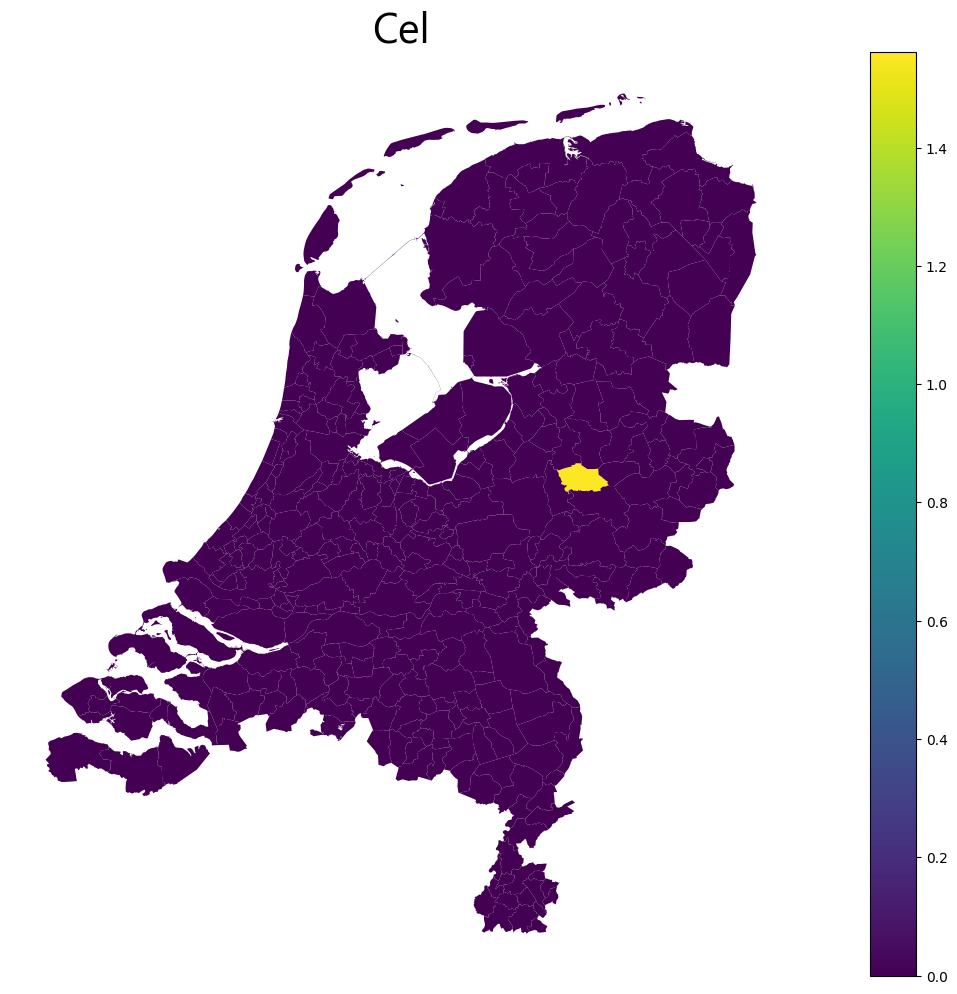

In [23]:
gemeente_boundaries_log_scale = gemeente_boundaries
for fn in ['Kantoor', 'Winkel', 'Onderwijs','Bijeenkomst', 'Sport', 'Woon', 'Gezondheidszorg', 'Logies', \
       'Overige', 'Industrie', 'Cel']:
    
    # converts it logarthmic scale
    #gemeente_boundaries_log_scale[fn]     = gemeente_boundaries_log_scale[fn].fillna(1)
    #gemeente_boundaries_log_scale[fn].replace(0,1, inplace = True,regex=False)
    #gemeente_boundaries_log_scale[fn]     = np.log10(gemeente_boundaries_log_scale[fn])
    #gemeente_boundaries_log_scale[fn]     = gemeente_boundaries_log_scale[fn].fillna(0)
    #p = gemeente_boundaries_log_scale.plot(column= fn, figsize = (20,12), legend = True, markersize = 12, cmap = 'viridis')
    p = gemeente_boundaries.plot(column= fn, figsize = (20,12), legend = True, markersize = 12, cmap = 'viridis')
    fig = p.figure
    cb_ax = fig.axes[0]
    cb_ax.tick_params(labelsize=25)
    p.set_title(fn, fontsize = 30,color = "black",fontname="Segoe UI")
    p.axis('off')
    #plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//functies//map_"+fn+"_percentage_function_gemeente.svg", format='svg',bbox_inches = 'tight')
    #plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//functies//map_"+fn+"_percentage_function_gemeente.png", format='png', dpi=500,bbox_inches = 'tight')

## Mean/Median distance for polling station

In [24]:
stem_distance = pd.read_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Analyses//gemeente_level//distances_on_gemeentelevel.xlsx")

In [25]:
stem_distance['gemeentecode'] = stem_distance['gemeentecode'].apply(lambda x: str(x).zfill(4))

In [26]:
gemeentegrenzen

gml_id  fid statcode        statnaam   rubriek  jrstatcode  \
0      gemeente_2023.0    1   GM0014       Groningen  gemeente  2023GM0014   
1      gemeente_2023.1    2   GM0034          Almere  gemeente  2023GM0034   
2      gemeente_2023.2    3   GM0037     Stadskanaal  gemeente  2023GM0037   
3      gemeente_2023.3    4   GM0047         Veendam  gemeente  2023GM0047   
4      gemeente_2023.4    5   GM0050        Zeewolde  gemeente  2023GM0050   
..                 ...  ...      ...             ...       ...         ...   
337  gemeente_2023.337  342   GM1979       Eemsdelta  gemeente  2023GM1979   
338  gemeente_2023.338  343   GM1980   Dijk en Waard  gemeente  2023GM1980   
339  gemeente_2023.339  344   GM1982  Land van Cuijk  gemeente  2023GM1982   
340  gemeente_2023.340  345   GM1991       Maashorst  gemeente  2023GM1991   
341  gemeente_2023.341  346   GM1992  Voorne aan Zee  gemeente  2023GM1992   

                                              geometry  
0    MULTIPOLYGON (((245194.691 592594.007, 245344....  
1    MULTIPOLYGON (((146891.056 493291.709, 147422....  
2    MULTIPOLYGON (((263763.866 566430.392, 263988....  
3    MULTIPOLYGON (((256231.909 572319.213, 258595....  
4    MULTIPOLYGON (((170596.293 486786.456, 170560....  
..                                                 ...  
337  MULTIPOLYGON (((254210.030 603122.465, 254836....  
338  MULTIPOLYGON (((114571.098 526107.935, 114660....  
339  MULTIPOLYGON (((181384.076 418252.229, 182100....  
340  MULTIPOLYGON (((176672.671 418565.125, 176593....  
341  MULTIPOLYGON (((72801.310 429725.840, 72964.48...  

[342 rows x 7 columns]

Text(0.5, 1.0, 'Mediane afstand tot stemlokalen')

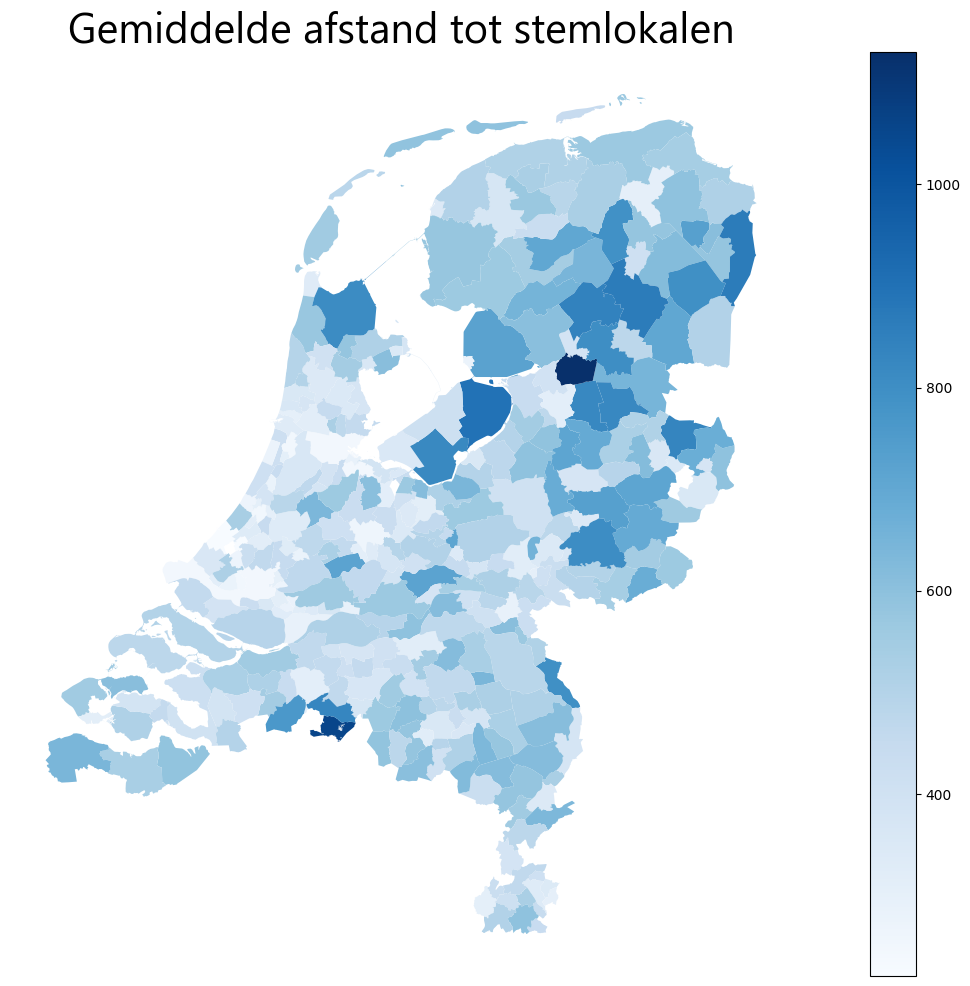

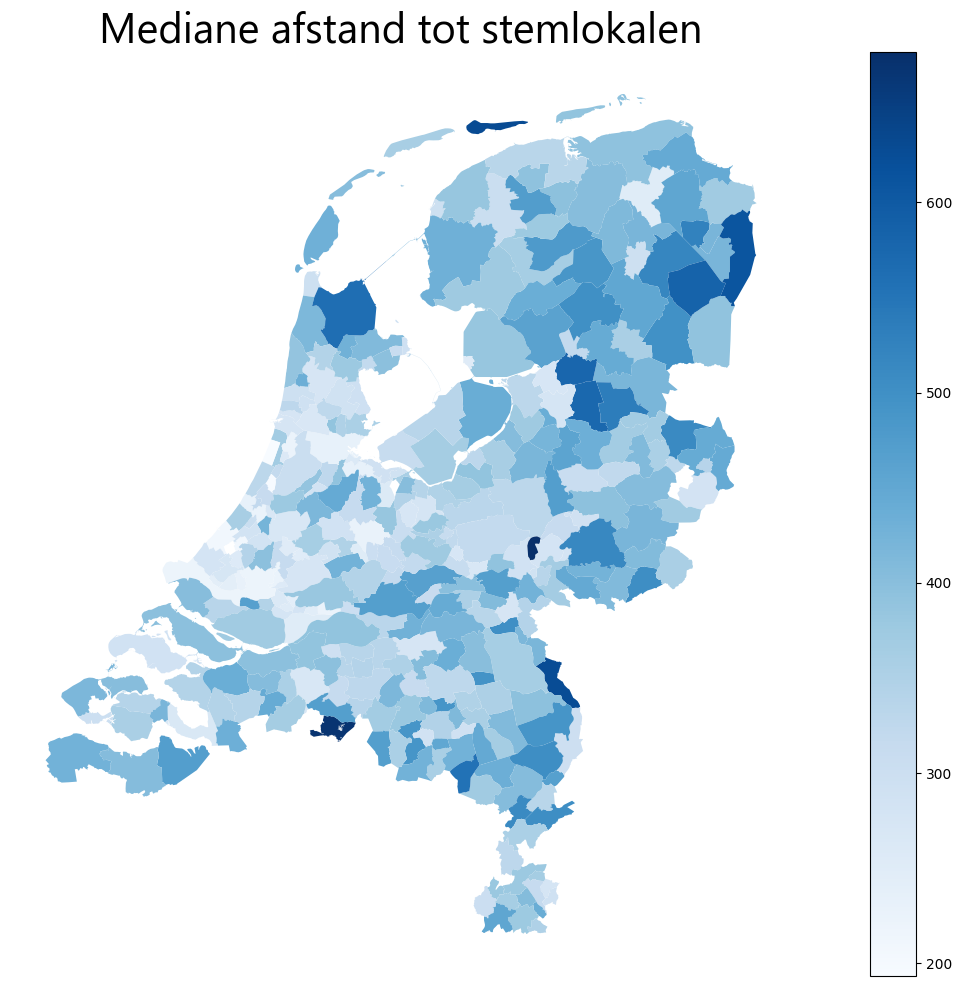

In [27]:
polling_station_distance = pd.merge(gemeentegrenzen,stem_distance,left_on= 'statnaam', right_on='gemeente')

#plt.rcParams["figure.figsize"] = [10,5]

# Mean distance

p = polling_station_distance.plot(column= 'dist_mean', figsize = (20,12), legend = True, markersize = 12, cmap = 'Blues')
fig = p.figure
cb_ax = fig.axes[0]
cb_ax.tick_params(labelsize=25)
p.axis('off')

p.set_title('Gemiddelde afstand tot stemlokalen', fontsize = 30,color = "black",fontname="Segoe UI")
#plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//map_mean_distance_polling_station.svg", format='svg',bbox_inches = 'tight')
#plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//map_mean_distance_polling_station.png", format='png', dpi=500,bbox_inches = 'tight')

# Median distance

p = polling_station_distance.plot(column= 'dist_median', figsize = (20,12), legend = True, markersize = 12, cmap = 'Blues')
fig = p.figure
cb_ax = fig.axes[0]
cb_ax.tick_params(labelsize=25)
p.axis('off')

p.set_title('Mediane afstand tot stemlokalen', fontsize = 30,color = "black",fontname="Segoe UI")
#plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//map_median_distance_polling_station.svg", format='svg',bbox_inches = 'tight')
#plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//map_median_distance_polling_station.png", format='png', dpi=500,bbox_inches = 'tight')


## Overview of Pooling station 

(3.164922179616244, 7.420954382443849, 50.61018354087219, 53.694230484679295)

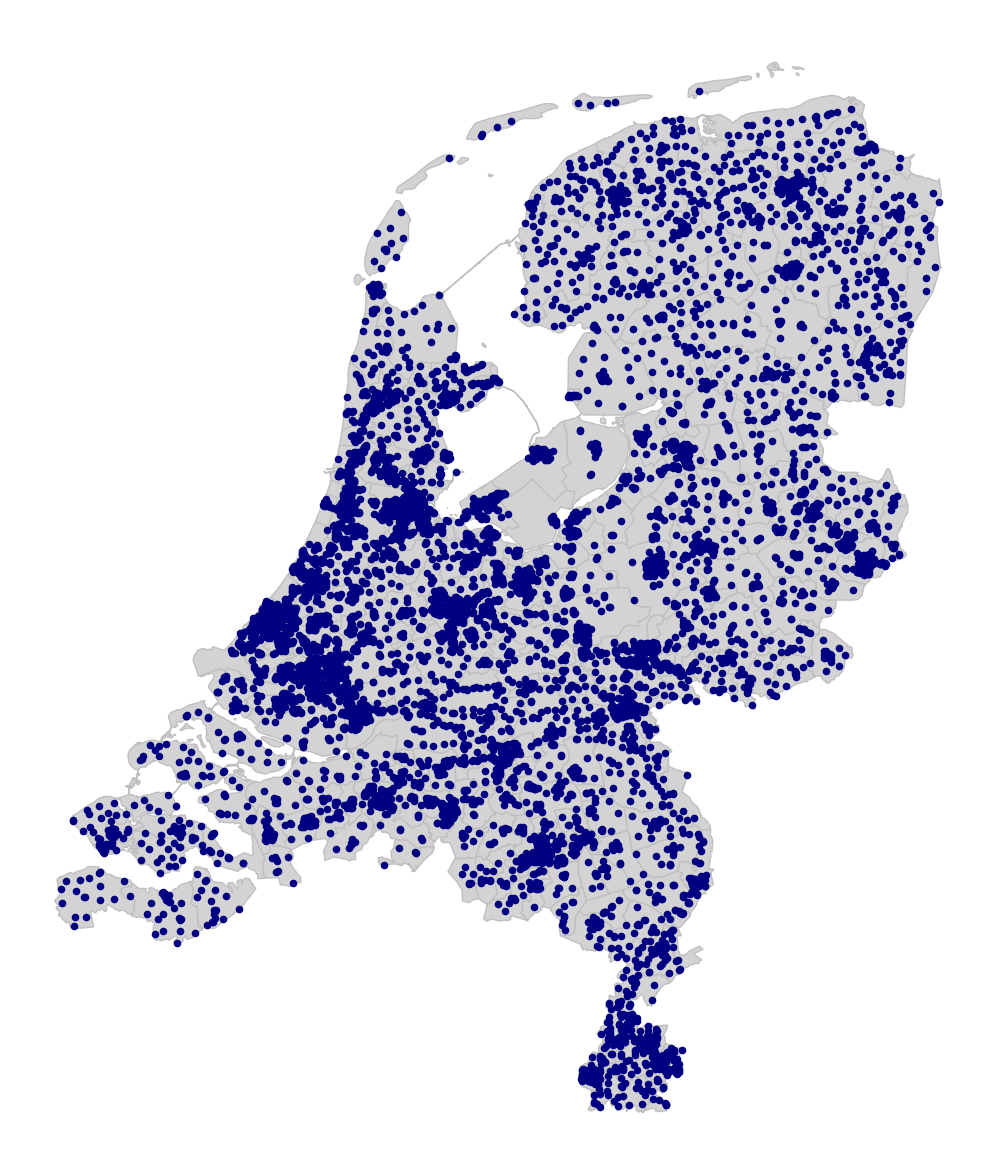

In [28]:
#geometry   = [Point(xy) for xy in zip(wims_data_all['Longitude'], wims_data_all['Latitude'])]

gdf = gpd.GeoDataFrame(gemeentegrenzen)

gdf = gdf.to_crs(epsg=4326)

#plt.scatter(wims_data_all['longitude'],wims_data_all['latitude'], s=10, color='Blue')

fig, ax = plt.subplots(figsize = (15,15))
gdf.plot(ax=ax, color='lightgrey',edgecolor='silver')
plt.scatter(wims_data_all['Longitude'],wims_data_all['Latitude'], s=20, color='Navy')
plt.axis('off')
#plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//map_Overview_polling_station.svg", format='svg',bbox_inches = 'tight')
#plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//map_Overview_polling_station.png", format='png', dpi=500,bbox_inches = 'tight')

##  Based on Opening time

In [30]:
wims_data_all['Openingstijd']      = pd.to_datetime(wims_data_all['Openingstijd'])
wims_data_all['Sluitingstijd']     = pd.to_datetime(wims_data_all['Sluitingstijd'])
wims_data_all['Openingsduur']      = round( (wims_data_all['Sluitingstijd'] - wims_data_all['Openingstijd'])/np.timedelta64(1,'h'),1 )

wims_data_all['Openingsduur_type'] = np.where(
    wims_data_all['Openingsduur'] == 13.5, 'Openingsduur regulier', np.where(
    wims_data_all['Openingsduur'] >  13.5, 'Openingsduur langer dan regulier', 'Openingsduur korter dan regulier')) 

stem_loken_opening_time = wims_data_all.groupby(['Gemeente','Openingsduur_type']).count().reset_index()[['Gemeente','Openingsduur_type','Naam stembureau']]
stem_loken_opening_time

Gemeente                 Openingsduur_type  Naam stembureau
0       's-Gravenhage  Openingsduur korter dan regulier                4
1       's-Gravenhage  Openingsduur langer dan regulier                2
2       's-Gravenhage             Openingsduur regulier              249
3    's-Hertogenbosch  Openingsduur korter dan regulier                1
4    's-Hertogenbosch             Openingsduur regulier               77
..                ...                               ...              ...
422       Zwijndrecht  Openingsduur korter dan regulier                2
423       Zwijndrecht  Openingsduur langer dan regulier                1
424       Zwijndrecht             Openingsduur regulier               14
425            Zwolle  Openingsduur korter dan regulier                4
426            Zwolle             Openingsduur regulier               65

[427 rows x 3 columns]

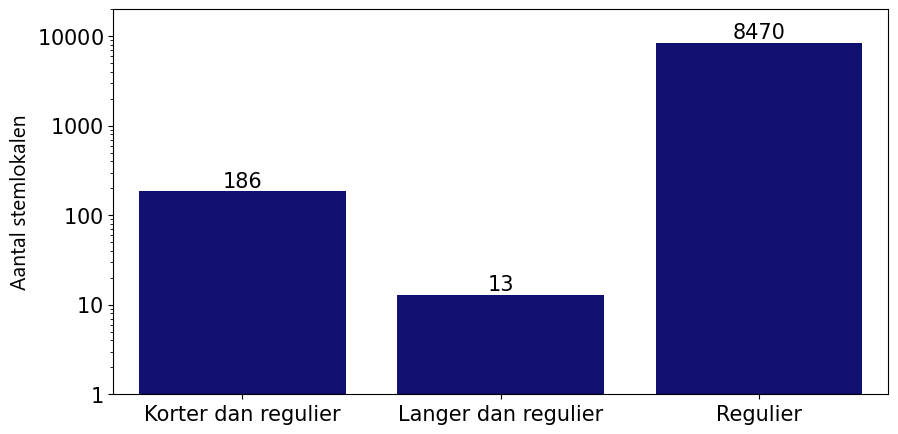

In [31]:
plt.rcParams['axes.formatter.min_exponent'] = 5
pie_chart                 = stem_loken_opening_time.groupby(['Openingsduur_type']).sum().reset_index()
pie_chart['stembureau percentage'] = pie_chart['Naam stembureau']*100/pie_chart['Naam stembureau'].sum()
pie_chart.replace('Openingsduur korter dan regulier','Korter dan regulier',inplace= True)
pie_chart.replace('Openingsduur langer dan regulier','Langer dan regulier',inplace= True)
pie_chart.replace('Openingsduur regulier','Regulier',inplace= True)
# declaring exploding pie
explode = [0.2, 0.2, 0.2]
# define Seaborn color palette to use
palette_color = sns.color_palette('deep')
fig = plt.figure()  
ax = sns.barplot(data=pie_chart,x='Openingsduur_type',y='Naam stembureau',color= 'navy')

ax.set_yscale("log")
ax.set_ylim(1e0,2e4)
plt.xlabel('',fontsize=15,fontname="Segoe UI")
plt.ylabel('Aantal stemlokalen',fontsize=15,fontname="Segoe UI")
# label.
for i in ax.containers:
    ax.bar_label(i,fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
#fig.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//polling_sataion_count.svg", format='svg',bbox_inches = 'tight')
#fig.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//polling_sataion_count.png", format='png', dpi=500,bbox_inches = 'tight')

In [32]:
Gemeente_different_not_normal_time = stem_loken_opening_time.loc[stem_loken_opening_time.Openingsduur_type!='Openingsduur regulier']
gemeente_not_normal_time_list      = list(Gemeente_different_not_normal_time['Gemeente'])
gemeente_not_normal_time           = stem_loken_opening_time.loc[stem_loken_opening_time['Gemeente'].isin(gemeente_not_normal_time_list)]
gemeente_not_normal_time           = gemeente_not_normal_time.groupby(['Gemeente','Openingsduur_type']).sum().reset_index()
print(gemeente_not_normal_time)
unique_gemeente_name_with_not_normal_time = list(set(gemeente_not_normal_time.Gemeente))

gemeente_with_not_normal_time = pd.DataFrame()

for gm in unique_gemeente_name_with_not_normal_time:
    tempDF             = gemeente_not_normal_time.loc[gemeente_not_normal_time.Gemeente==gm]
    tempDF['Percent']  = tempDF['Naam stembureau']*100/tempDF['Naam stembureau'].sum()
    gemeente_with_not_normal_time = pd.concat([gemeente_with_not_normal_time,tempDF])

             Gemeente                 Openingsduur_type  Naam stembureau
0       's-Gravenhage  Openingsduur korter dan regulier                4
1       's-Gravenhage  Openingsduur langer dan regulier                2
2       's-Gravenhage             Openingsduur regulier              249
3    's-Hertogenbosch  Openingsduur korter dan regulier                1
4    's-Hertogenbosch             Openingsduur regulier               77
..                ...                               ...              ...
160       Zwijndrecht  Openingsduur korter dan regulier                2
161       Zwijndrecht  Openingsduur langer dan regulier                1
162       Zwijndrecht             Openingsduur regulier               14
163            Zwolle  Openingsduur korter dan regulier                4
164            Zwolle             Openingsduur regulier               65

[165 rows x 3 columns]


In [33]:
gemeente_with_not_normal_time[gemeente_with_not_normal_time['Gemeente']=="'s-Gravenhage"]

Gemeente                 Openingsduur_type  Naam stembureau    Percent
0  's-Gravenhage  Openingsduur korter dan regulier                4   1.568627
1  's-Gravenhage  Openingsduur langer dan regulier                2   0.784314
2  's-Gravenhage             Openingsduur regulier              249  97.647059

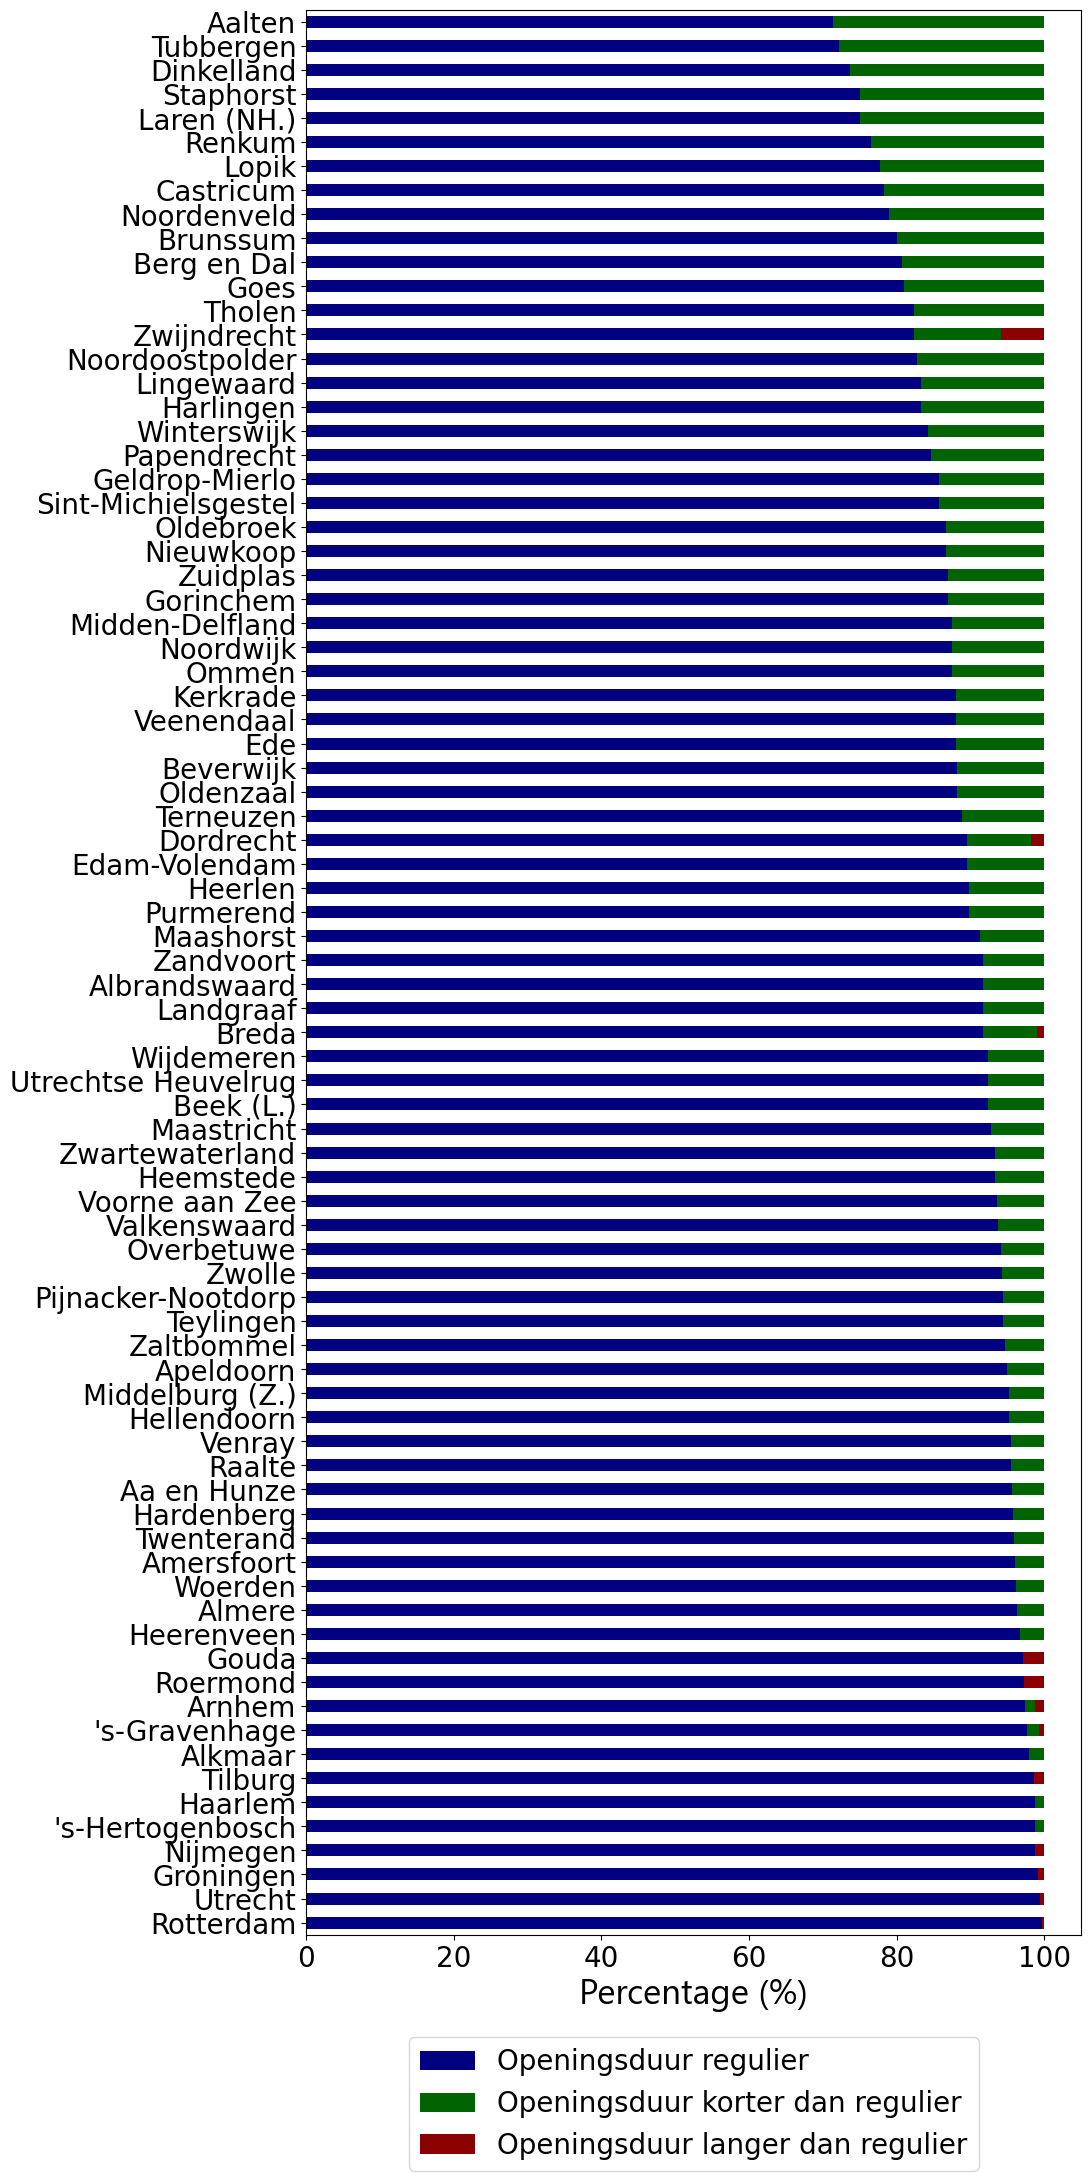

In [34]:
# create stacked bar chart for monthly temperatures
gemeente_with_not_normal_time = gemeente_with_not_normal_time[['Gemeente','Openingsduur_type','Percent']]

gemeente_with_not_normal_time_plot = pd.DataFrame()

unique_gemeente_name_with_not_normal_time = list(set(gemeente_with_not_normal_time.Gemeente))

gemeente                            = []
Openingsduur_afwijkend              = []
Openingsduur_korter_dan_regulier    = []
Openingsduur_langer_dan_regulier    = []

for gm in unique_gemeente_name_with_not_normal_time:
    gemeente.append(gm)
    temp_df = gemeente_with_not_normal_time[gemeente_with_not_normal_time.Gemeente==gm]
    try:
        Openingsduur_afwijkend.append(float(temp_df[temp_df['Openingsduur_type']=='Openingsduur regulier']['Percent']))
    except:
        Openingsduur_afwijkend.append(0)
    try:
        Openingsduur_korter_dan_regulier.append(float(temp_df[temp_df['Openingsduur_type']=='Openingsduur korter dan regulier']['Percent']))
    except:
        Openingsduur_korter_dan_regulier.append(0)
    try:
        Openingsduur_langer_dan_regulier.append(float(temp_df[temp_df['Openingsduur_type']=='Openingsduur langer dan regulier']['Percent']))
    except:
        Openingsduur_langer_dan_regulier.append(0)     
        
gemeente_with_not_normal_time_plot['gemeente']                          =   gemeente
gemeente_with_not_normal_time_plot['Openingsduur regulier']            =   Openingsduur_afwijkend
gemeente_with_not_normal_time_plot['Openingsduur korter dan regulier']  =   Openingsduur_korter_dan_regulier
gemeente_with_not_normal_time_plot['Openingsduur langer dan regulier']   =   Openingsduur_langer_dan_regulier

gemeente_with_not_normal_time_plot = gemeente_with_not_normal_time_plot.sort_values(by = 'Openingsduur regulier', ascending= False)
#gemeente_with_not_normal_time_plot = gemeente_with_not_normal_time_plot.sort_values(by = 'Openingsduur korter dan regulier', ascending= False)
# plot data in stack manner of bar type
gemeente_with_not_normal_time_plot.to_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Files//non_regular_hour_opening.xlsx")
cmaps = ['navy','darkgreen','darkred']
#cmaps = sns.color_palette('Blues_r')
gemeente_with_not_normal_time_plot.plot(x='gemeente',kind='barh', stacked=True, color =cmaps,figsize = (10,25))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Percentage (%)',fontsize=25,fontname="Segoe UI")
plt.ylabel('',fontsize=15,fontname="Segoe UI")
#plt.rcParams["figure.figsize"] = [20,10]
plt.legend(bbox_to_anchor =(0.5,-0.13), loc='lower center',ncol=1,fontsize=20)
#plt.tight_layout()

plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//non_regular_hour_opening.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//non_regular_hour_opening.png", format='png', dpi=500,bbox_inches = 'tight')
plt.show()

## Population Distribution

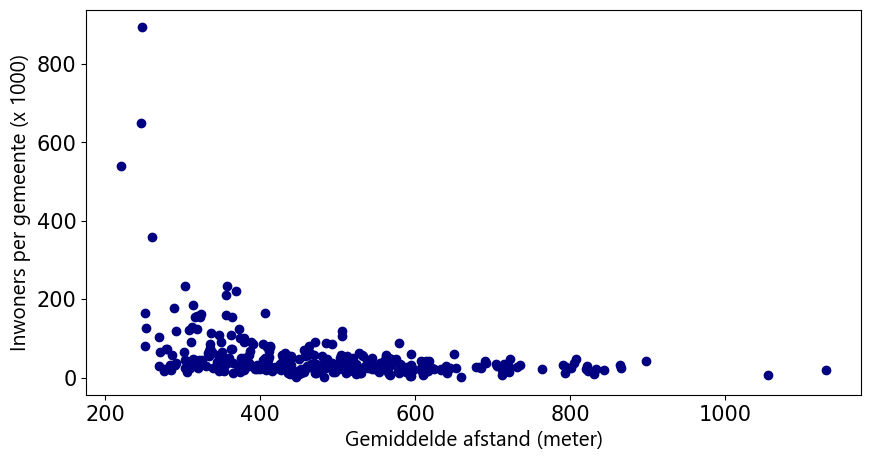

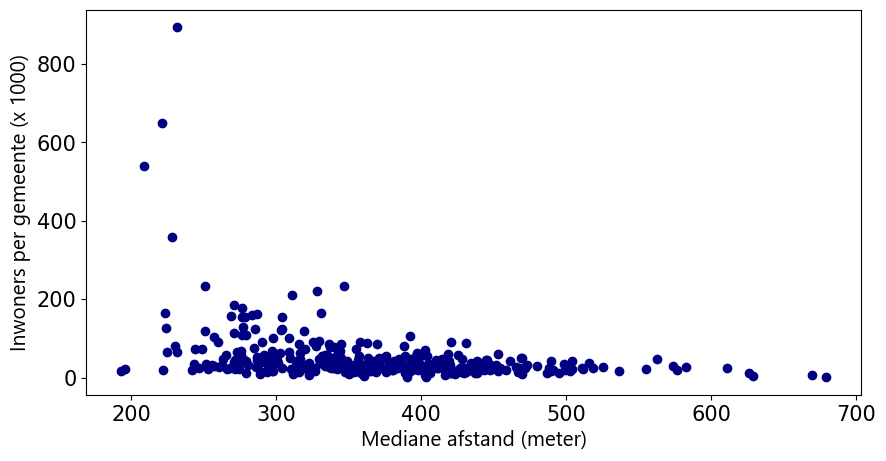

In [35]:
# Scatter Plot

gemeente_analyse = "G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Analyses//gemeente_level//"
g1_file          = "distances_on_gemeentelevel.xlsx"  
gemeente_data_analyse = pd.read_excel(gemeente_analyse+g1_file)

gemeente_data_analyse.inwoners = gemeente_data_analyse.inwoners/1000

plt.rcParams["figure.figsize"] = [10,5]
plt.scatter(gemeente_data_analyse['dist_mean'],gemeente_data_analyse.inwoners,color = ['navy'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Gemiddelde afstand (meter)',fontsize=15,fontname="Segoe UI")
plt.ylabel('Inwoners per gemeente (x 1000)',fontsize=15,fontname="Segoe UI")
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//Population_Distribution_mean.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//Population_Distribution_mean.png", format='png', dpi=500,bbox_inches = 'tight')
plt.show()

plt.rcParams["figure.figsize"] = [10,5]
plt.scatter(gemeente_data_analyse['dist_median'],gemeente_data_analyse.inwoners,color = ['navy'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Mediane afstand (meter)',fontsize=15,fontname="Segoe UI")
plt.ylabel('Inwoners per gemeente (x 1000)',fontsize=15,fontname="Segoe UI")
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//Population_Distribution_median.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//Population_Distribution_median.png", format='png', dpi=500,bbox_inches = 'tight')
plt.show()

##  Analysis of mobile polling station

In [36]:
wims_data_all_mobile = wims_data_all[wims_data_all['Type stembureau']=='mobiel']

mobile_stembureau =  wims_data_all_mobile[wims_data_all_mobile['Naam stembureau'].str.contains("Tent", case=False)|
                     wims_data_all_mobile['Naam stembureau'].str.contains("Drive", case=False)|
                     wims_data_all_mobile['Naam stembureau'].str.contains("Tijdelijke", case=False)|
                     wims_data_all_mobile['Naam stembureau'].str.contains("Grasveld", case=False)|
                     wims_data_all_mobile['Naam stembureau'].str.contains("Parkeer", case=False)|
                     wims_data_all_mobile['Naam stembureau'].str.contains("Station", case=False)|
                     wims_data_all_mobile['Naam stembureau'].str.contains('Portocabin', case=False)|
                     wims_data_all_mobile['Naam stembureau'].str.contains("Keet", case=False)|
                     wims_data_all_mobile['Naam stembureau'].str.contains("Unit ", case=False)|
                     wims_data_all_mobile['Naam stembureau'].str.contains('Stembus', case=False)|
                     wims_data_all_mobile['Naam stembureau'].str.contains('trolleybus', case=False)|
                     wims_data_all_mobile['Naam stembureau'].str.contains('verkiezingsbus', case=False)|
                     wims_data_all_mobile['Extra adresaanduiding'].str.contains("Tent", case=False)|
                     wims_data_all_mobile['Extra adresaanduiding'].str.contains("Drive", case=False)|
                     wims_data_all_mobile['Extra adresaanduiding'].str.contains("Tijdelijke", case=False)|
                     wims_data_all_mobile['Extra adresaanduiding'].str.contains("Grasveld", case=False)|
                     wims_data_all_mobile['Extra adresaanduiding'].str.contains("Parkeer", case=False)|
                     wims_data_all_mobile['Extra adresaanduiding'].str.contains("Station", case=False)|
                     wims_data_all_mobile['Extra adresaanduiding'].str.contains('Portocabin', case=False)|
                     wims_data_all_mobile['Extra adresaanduiding'].str.contains("Keet", case=False)|
                     wims_data_all_mobile['Extra adresaanduiding'].str.contains("Unit ", case=False)|
                     wims_data_all_mobile['Extra adresaanduiding'].str.contains('Stembus', case=False)|
                     wims_data_all_mobile['Extra adresaanduiding'].str.contains('trolleybus', case=False)|
                     wims_data_all_mobile['Extra adresaanduiding'].str.contains('verkiezingsbus', case=False)]
                                          
print("Total mobile stembureau is {}".format(len(mobile_stembureau)))

mobile_stembureau.to_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Files//mobile_stembureau.xlsx")    

Total mobile stembureau is 123


In [37]:
wims_data_all_mobile.shape

(189, 21)

In [38]:
word_list_for_mobile = ['Tent','Drive','Tijdelijke','Grasveld','Station','Portocabin', "Keet","Unit",'Parkeer',
                       'Stembus','trolleybus','verkiezingsbus']

mobiel_type = []
Counts      = []


for word in word_list_for_mobile:
    temp_data = wims_data_all_mobile[wims_data_all_mobile['Naam stembureau'].str.contains(word, case=False)|
                                     wims_data_all_mobile['Extra adresaanduiding'].str.contains(word, case=False)]
    print("Total mobile for {} is {}".format(word, len(temp_data)))
    #temp_data.to_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Files//mobiel_type"+word+".xlsx")    
    mobiel_type.append(word.capitalize())
    Counts.append(len(temp_data))
df_count = pd.DataFrame()
df_count['mobiel_type'] = mobiel_type
df_count['Counts']      = Counts
df_count['Percent']     = df_count['Counts']*100/df_count['Counts'].sum()
#df_count.to_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Files//mobiel_type_count.xlsx")      
        

Total mobile for Tent is 40
Total mobile for Drive is 13
Total mobile for Tijdelijke is 11
Total mobile for Grasveld is 2
Total mobile for Station is 38
Total mobile for Portocabin is 7
Total mobile for Keet is 2
Total mobile for Unit is 6
Total mobile for Parkeer is 26
Total mobile for Stembus is 4
Total mobile for trolleybus is 1
Total mobile for verkiezingsbus is 5


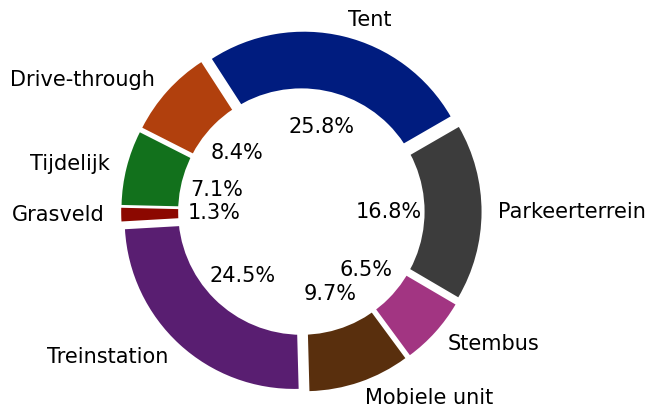

In [64]:
# declaring exploding pie
df_mobiel_plot = pd.read_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Files//mobiel_type_count.xlsx",sheet_name='Graph')
explode = (0.07, 0.07, 0.07, 0.07, 0.07,0.07, 0.07, 0.07)

# define Seaborn color palette to use
palette_color = sns.color_palette('dark')
  
# plotting data on chart
plt.pie(df_mobiel_plot.Counts, labels=df_mobiel_plot.mobiel_type, colors=palette_color,explode=explode,radius=1.1,
 autopct='%1.1f%%', textprops={'fontsize': 15}, pctdistance= 0.45, startangle = 30)

# draw circle

centre_circle = plt.Circle((0, 0), 0.8, fc='white')

fig = plt.gcf()

# Adding Circle in Pie chart

fig.gca().add_artist(centre_circle)

plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//mobiel_type.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//mobiel_type.png", format='png', dpi=500,bbox_inches = 'tight')
plt.show()

## Read Turn up files

In [40]:
turn_up_data = pd.read_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Data//Kiesraad_data//Tellingen_PS_2023vs2019 tbv centerdata_20230404_v3.xlsx",sheet_name ="PS2023")
turn_up_data['Fraction_turn_up'] = turn_up_data['TotalCounted']*100/turn_up_data['Cast']
turn_up_data.shape

(342, 10)

In [41]:
turn_up_data[turn_up_data['Fraction_turn_up']==turn_up_data['Fraction_turn_up'].max()]

GemeenteCode GemeenteNaam            CreationDate ElectionIdentifier  \
261           180    Staphorst 2023-03-16 16:31:04.480  PS2023_Overijssel   

     Aantal_SB  Verschil \naantal SB \n2023 -2019   Cast  TotalCounted  \
261         12                                  3  12644         10644   

     Gemiddeld stemmen \nper SB  Fraction_turn_up  
261                       887.0         84.182221

In [42]:
turn_up_data[turn_up_data['Fraction_turn_up']==turn_up_data['Fraction_turn_up'].min()]

GemeenteCode GemeenteNaam            CreationDate  ElectionIdentifier  \
241           599    Rotterdam 2023-03-17 00:17:24.680  PS2023_ZuidHolland   

     Aantal_SB  Verschil \naantal SB \n2023 -2019    Cast  TotalCounted  \
241        299                                 18  459490        193783   

     Gemiddeld stemmen \nper SB  Fraction_turn_up  
241                  648.103679         42.173497

## Turn Up Vs Distance

(342, 17)


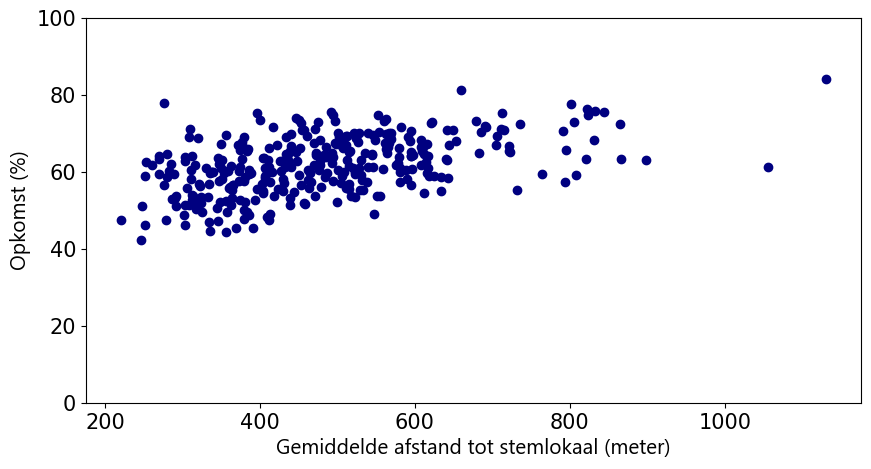

AttributeError: 'Text' object has no property 'textname'

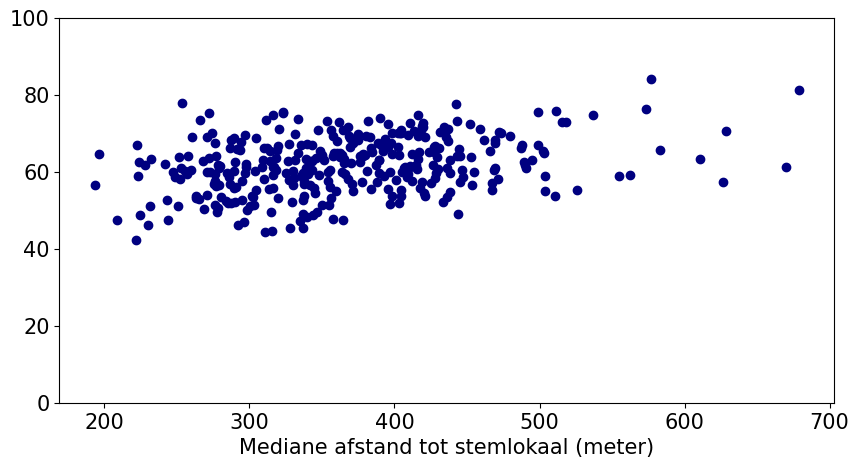

In [43]:
# merge kwb data and turn up data

turn_up_vs_distance = pd.merge(turn_up_data,gemeente_data_analyse,left_on='GemeenteCode',right_on='gemeentecode')
print(turn_up_vs_distance.shape)

plt.rcParams["figure.figsize"] = [10,5]
plt.scatter(turn_up_vs_distance['dist_mean'],turn_up_vs_distance['Fraction_turn_up'],color = ['navy'])
plt.ylim(0, 100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Gemiddelde afstand tot stemlokaal (meter)',fontsize=15,fontname="Segoe UI")
plt.ylabel('Opkomst (%)',fontsize=15,fontname="Segoe UI")

plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//Dist_meanVsVoting_gemeente.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//Dist_meanVsVoting_gemeente.png", format='png', dpi=500,bbox_inches = 'tight')
plt.show()

plt.rcParams["figure.figsize"] = [10,5]
plt.scatter(turn_up_vs_distance['dist_median'],turn_up_vs_distance['Fraction_turn_up'],color = ['navy'])
plt.ylim(0, 100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xlabel('Mediane afstand tot stemlokaal (meter)',fontsize=15,fontname="Segoe UI")
plt.xlabel('Mediane afstand tot stemlokaal (meter)',fontsize=15,textname ="Segoe UI")
plt.ylabel('Opkomst (%)',fontsize=15,fontname="Segoe UI")
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//Dist_medianVsVoting_gemeente_median.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//Dist_medianVsVoting_gemeente_median.png", format='png', dpi=500,bbox_inches = 'tight')
plt.show()
#
# correlation 
corr = turn_up_vs_distance['dist_mean'].corr(turn_up_vs_distance['Fraction_turn_up'])
print("Correlation between is dist_mean and turn up is {}".format(corr))

corr = turn_up_vs_distance['dist_median'].corr(turn_up_vs_distance['Fraction_turn_up'])
print("Correlation between is dist_median and turn up is {}".format(corr))

turn_up_vs_distance.to_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Files//turn_up_vs_distance.xlsx")

## T-test (P-value)

In [44]:
from scipy.stats import ttest_ind
#perform independent two sample t-test
ttest_ind(turn_up_vs_distance['dist_mean'], turn_up_vs_distance['Fraction_turn_up'])

Ttest_indResult(statistic=53.58920317173429, pvalue=1.1616078857336863e-246)

In [45]:
from scipy import stats
statistic, pval = stats.mannwhitneyu(turn_up_vs_distance['dist_mean'], turn_up_vs_distance['Fraction_turn_up'], method='exact')
print(pval)

8.170707886552435e-205


## Turn Up Vs Income

In [46]:
KWB_data_2022 = pd.read_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Data//CBS_data//kwb-2022.xlsx", thousands='.')                   
KWB_data_2022_gm = KWB_data_2022[KWB_data_2022['recs']=='Gemeente']
KWB_data_2022_gm.reset_index(drop = True, inplace= True)

KWB_data_2021 = pd.read_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Data//CBS_data//kwb-2021.xlsx", thousands='.')                   
KWB_data_2021_gm = KWB_data_2021[KWB_data_2021['recs']=='Gemeente']
KWB_data_2021_gm.reset_index(drop = True, inplace= True)

KWB_data_2020 = pd.read_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Data//CBS_data//kwb-2020.xlsx", thousands='.')                   
KWB_data_2020_gm = KWB_data_2020[KWB_data_2020['recs']=='Gemeente']
KWB_data_2020_gm.reset_index(drop = True, inplace= True)

KWB_data_2019 = pd.read_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Data//CBS_data//kwb-2019.xlsx", thousands='.')                   
KWB_data_2019_gm = KWB_data_2019[KWB_data_2019['recs']=='Gemeente']
KWB_data_2019_gm.reset_index(drop = True, inplace= True)

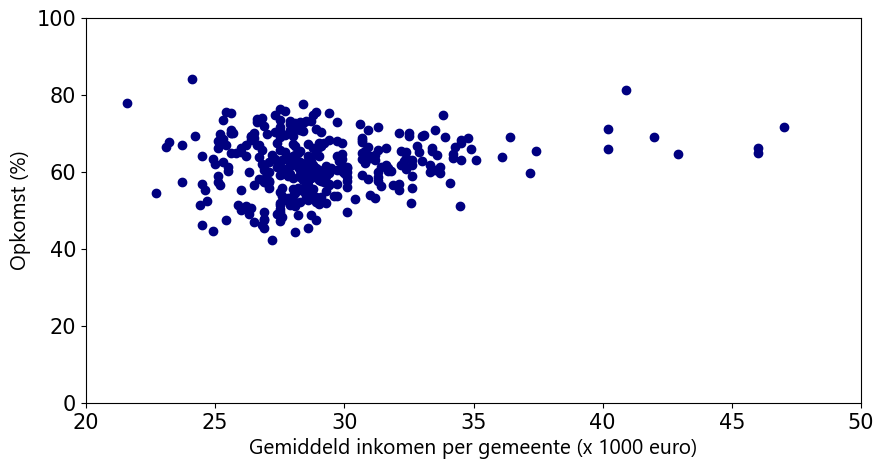

In [47]:
# income vs turn out

mapping_to_23 = pd.read_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Data//Gemeente_data//GemeenteMapped2022//_2021.xlsx")

# map 2022 gemeente to 2023 gemeente in KWB data

gm_23 = []
for i in range(len(KWB_data_2021_gm)):
    tempgm = mapping_to_23[mapping_to_23['GemeentecodeGM']==KWB_data_2021_gm['gwb_code_10'][i]]
    tempgm.reset_index(drop=True, inplace= True)
    gm_23.append(tempgm['_2023'][0]) 
                              
KWB_data_2021_gm['GM2023'] = gm_23  

# No income for Schiermonnikoog, Vlieland Rozendaal in 2021
# Impute it using datat from 2020

for gm in ['Schiermonnikoog', 'Vlieland' ,'Rozendaal']:
    KWB_data_2021_gm.loc[KWB_data_2021_gm['gm_naam']==gm,'a_inw']=(KWB_data_2020_gm[KWB_data_2020_gm['gm_naam']==gm]['a_inw'])._values[0]
    KWB_data_2021_gm.loc[KWB_data_2021_gm['gm_naam']==gm,'g_ink_pi']=(KWB_data_2020_gm[KWB_data_2020_gm['gm_naam']==gm]['g_ink_pi'])._values[0]
# 'gwb_code_10','a_15_24','a_25_44','a_45_64','a_65_oo'
KWB_data_gm_2021_select = KWB_data_2021_gm[['a_inw','g_ink_pi','GM2023']]
KWB_data_gm_2021_select['g_ink_pi']     = KWB_data_gm_2021_select['g_ink_pi'].str.replace(',','.',regex=True)
KWB_data_gm_2021_select['g_ink_pi']     = KWB_data_gm_2021_select['g_ink_pi'].astype(float)
KWB_data_gm_2021_select['total_income'] = KWB_data_gm_2021_select['a_inw']* KWB_data_gm_2021_select['g_ink_pi']

KWB_data_gm_2021_select             = KWB_data_gm_2021_select.groupby('GM2023').sum().reset_index()
KWB_data_gm_2021_select['g_ink_pi'] = KWB_data_gm_2021_select['total_income']/KWB_data_gm_2021_select['a_inw']

turn_up_vs_income = pd.merge(turn_up_data,KWB_data_gm_2021_select,left_on='GemeenteNaam',right_on='GM2023')
turn_up_vs_income = turn_up_vs_income[turn_up_vs_income['g_ink_pi']!=0]
plt.scatter(turn_up_vs_income['g_ink_pi'],turn_up_vs_income['Fraction_turn_up'],color = ['navy'])
plt.ylim(0, 100)
plt.xlim(20, 50)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Gemiddeld inkomen per gemeente (x 1000 euro)',fontsize=15,fontname="Segoe UI")
plt.ylabel('Opkomst (%)',fontsize=15,fontname="Segoe UI")
plt.rcParams["figure.figsize"] = [10,5]
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//IncomeVsVoting_gemeente.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//IncomeVsVoting_gemeente.png", format='png', dpi=500,bbox_inches = 'tight')
plt.show()

turn_up_vs_income.to_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Files//IncomeVsVoting_gemeente.xlsx")

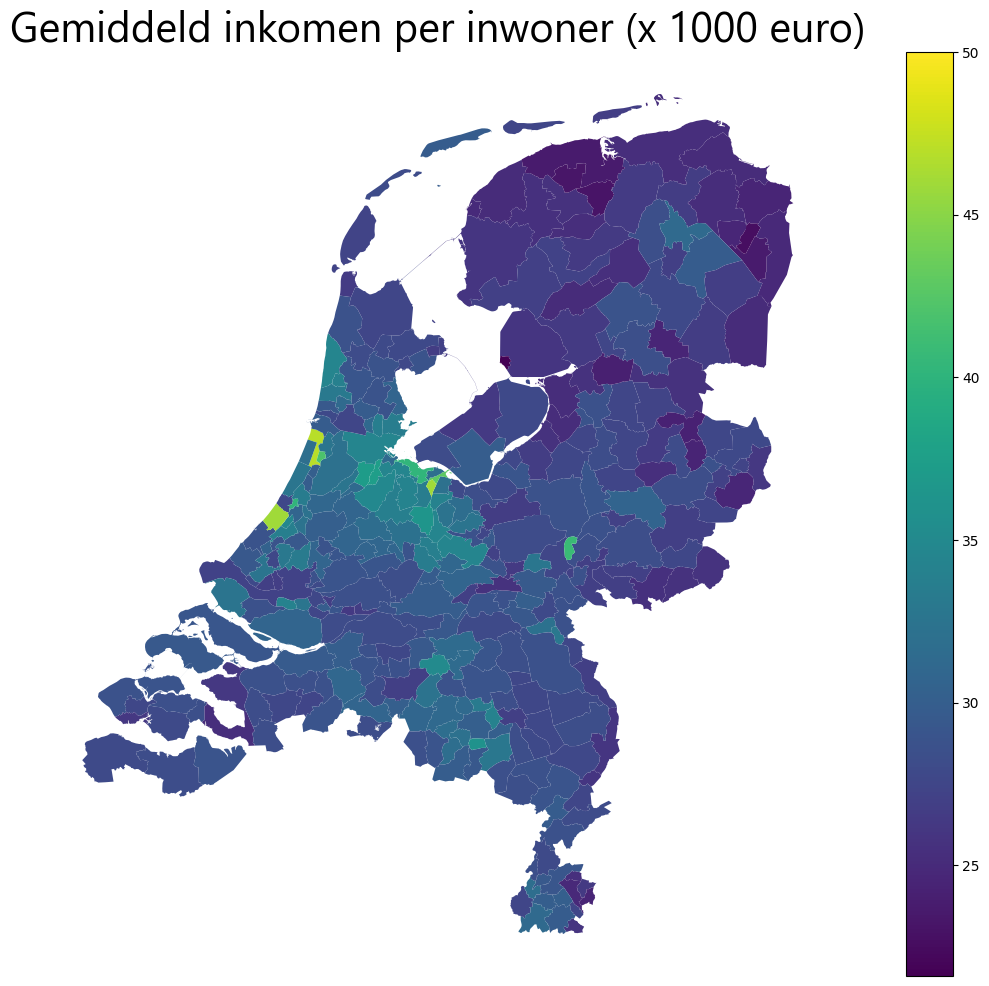

In [48]:
_income = turn_up_vs_income[['g_ink_pi','GemeenteCode']]

# Add 'GM' before code

_income['GemeenteCode'] = _income['GemeenteCode'].apply(lambda x: '{0:0>4}'.format(x))
_income['GemeenteCode'] = 'GM' + _income['GemeenteCode'].astype(str)


#national_income = pd.merge(gemeentegrenzen,_income,left_on= 'code', right_on='GemeenteCode')
national_income = pd.merge(gemeentegrenzen,_income,left_on= 'statcode', right_on='GemeenteCode')
p = national_income.plot(column= 'g_ink_pi', figsize = (20,12), legend = True, markersize = 12, cmap = 'viridis',vmax=50)
fig = p.figure
cb_ax = fig.axes[0]
cb_ax.tick_params(labelsize=25)
#p.set_title('Mediane afstand tot stemlokalen', fontsize = 30,color = "black",fontname="Segoe UI")
p.set_title('Gemiddeld inkomen per inwoner (x 1000 euro)', fontsize = 30,color = "black",fontname="Segoe UI")
p.axis('off')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//map_national_income.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//map_national_income.png", format='png', dpi=500,bbox_inches = 'tight')

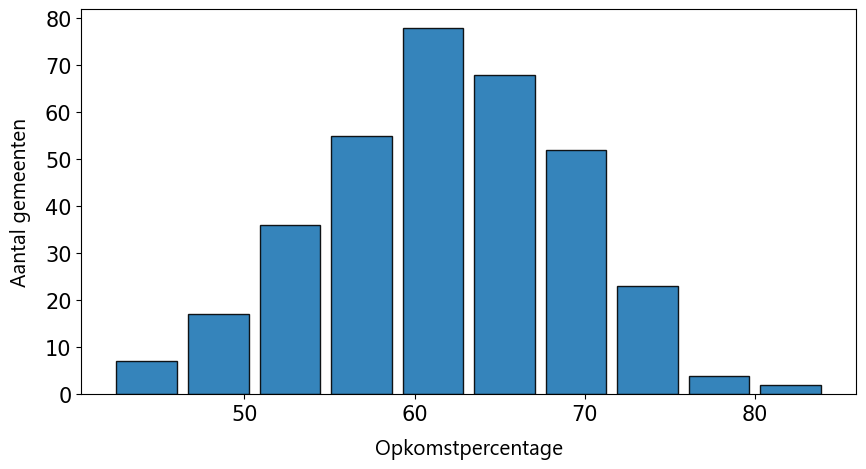

In [49]:
#ax = turn_up_vs_income['Fraction_turn_up'].plot.hist(bins=25, alpha=0.5,figsize=(10,5),color='navy', zorder=2, rwidth=1,edgecolor='black', linewidth=1)
ax = turn_up_vs_income['Fraction_turn_up'].plot.hist(bins=10, alpha=0.9,figsize=(10,5), zorder=2, rwidth=0.85, edgecolor='black', linewidth=1)
ax.set_ylabel("Aantal gemeenten", labelpad=10,fontsize=15,fontname="Segoe UI")
ax.set_xlabel("Opkomstpercentage", labelpad=10,fontsize=15,fontname="Segoe UI")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//VotingoverviewBin.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//VotingoverviewBin.png", format='png', dpi=500,bbox_inches = 'tight')

# Age Vs Turn up

Correlation above 65 is 0.10160093667214262
Correlation above 25_44 is -0.41985516365214787
Correlation above 45_64 is 0.002137989279494152


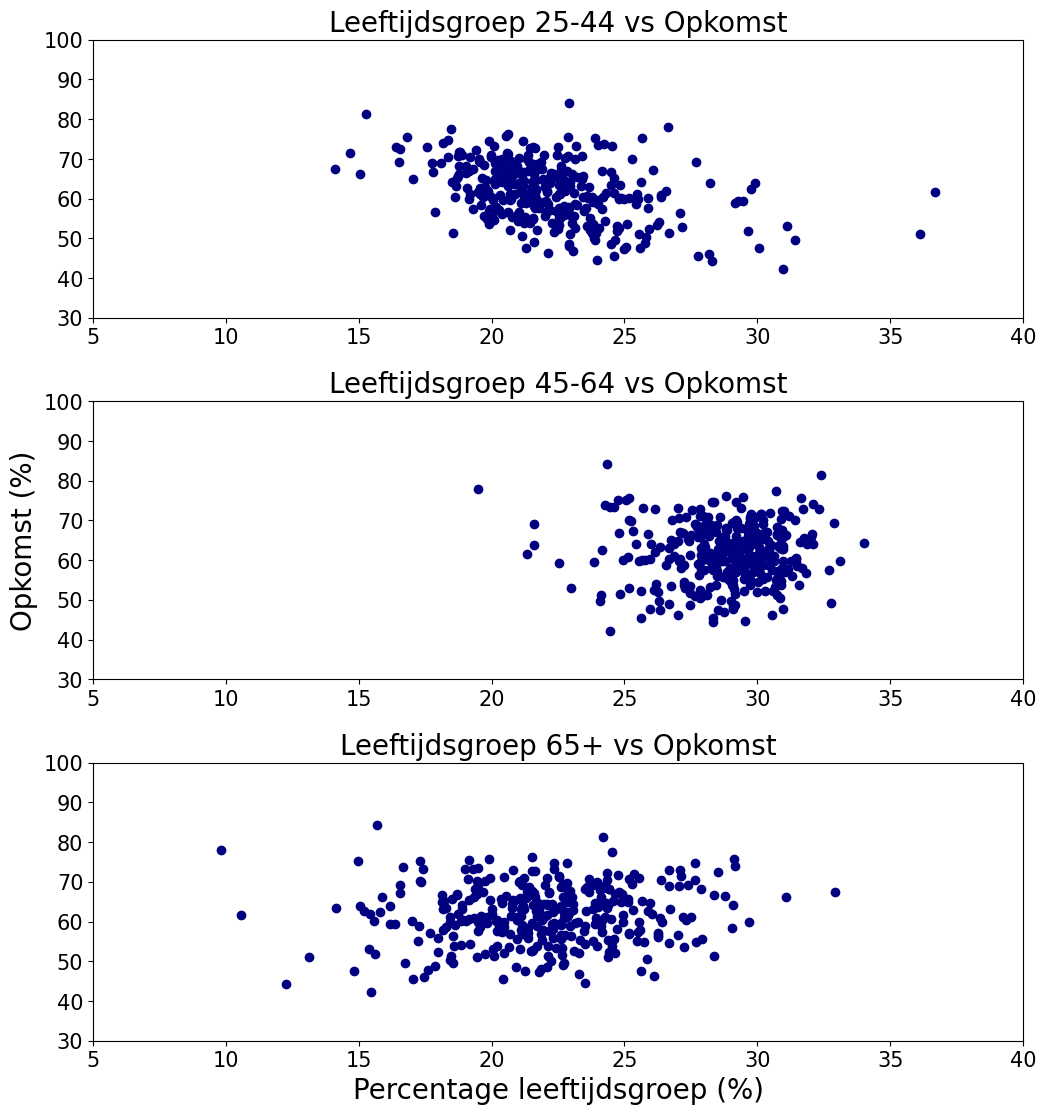

In [63]:
KWB_data_gm_2021_select_age = KWB_data_2021_gm[['a_65_oo','a_45_64','a_25_44','GM2023','a_inw']]
KWB_data_gm_2021_select_age = KWB_data_gm_2021_select_age.groupby('GM2023').sum().reset_index()
KWB_data_gm_2021_select_age['Plus65']   = KWB_data_gm_2021_select_age['a_65_oo']*100/(KWB_data_gm_2021_select_age['a_inw'])
KWB_data_gm_2021_select_age['bw_45_64'] = KWB_data_gm_2021_select_age['a_45_64']*100/(KWB_data_gm_2021_select_age['a_inw'])
KWB_data_gm_2021_select_age['bw_25_44'] = KWB_data_gm_2021_select_age['a_25_44']*100/(KWB_data_gm_2021_select_age['a_inw'])



turn_up_vs_age = pd.merge(turn_up_data,KWB_data_gm_2021_select_age,left_on='GemeenteNaam',right_on='GM2023')

print("Correlation above 65 is {}".format((turn_up_vs_age['Plus65']).corr(turn_up_vs_age['Fraction_turn_up'])))
print("Correlation above 25_44 is {}".format((turn_up_vs_age['bw_25_44']).corr(turn_up_vs_age['Fraction_turn_up'])))
print("Correlation above 45_64 is {}".format((turn_up_vs_age['bw_45_64']).corr(turn_up_vs_age['Fraction_turn_up'])))

plt.subplot(3,1,1)
plt.gcf().set_size_inches(12, 13)
plt.subplots_adjust(hspace = 0.3)
plt.scatter(turn_up_vs_age['bw_25_44'],turn_up_vs_age['Fraction_turn_up'],color = ['navy'])
plt.title("Leeftijdsgroep 25-44 vs Opkomst",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(30, 100)
plt.xlim(5, 40)
plt.subplot(3,1,2)
plt.scatter(turn_up_vs_age['bw_45_64'],turn_up_vs_age['Fraction_turn_up'],color = ['navy'])
plt.title("Leeftijdsgroep 45-64 vs Opkomst",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(30, 100)
plt.xlim(5, 40)
plt.ylabel('Opkomst (%)', fontsize=20)

plt.subplot(3,1,3)
plt.scatter(turn_up_vs_age['Plus65'],turn_up_vs_age['Fraction_turn_up'],color = ['navy'])
plt.title("Leeftijdsgroep 65+ vs Opkomst",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(30, 100)
plt.xlim(5, 40)

plt.xlabel('Percentage leeftijdsgroep (%)',fontsize=20)


plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//AgeGPVsTurnup.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//AgeGPVsTurnup.png", format='png', dpi=500,bbox_inches = 'tight')
plt.show()


#turn_up_vs_age.to_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Files//AgeGPVsTurnup.xlsx")

## Gender Vs Turn up

Correlation with Male is 0.11258091312540128
Correlation with female is -0.10381223327897865


(40.0, 55.0)

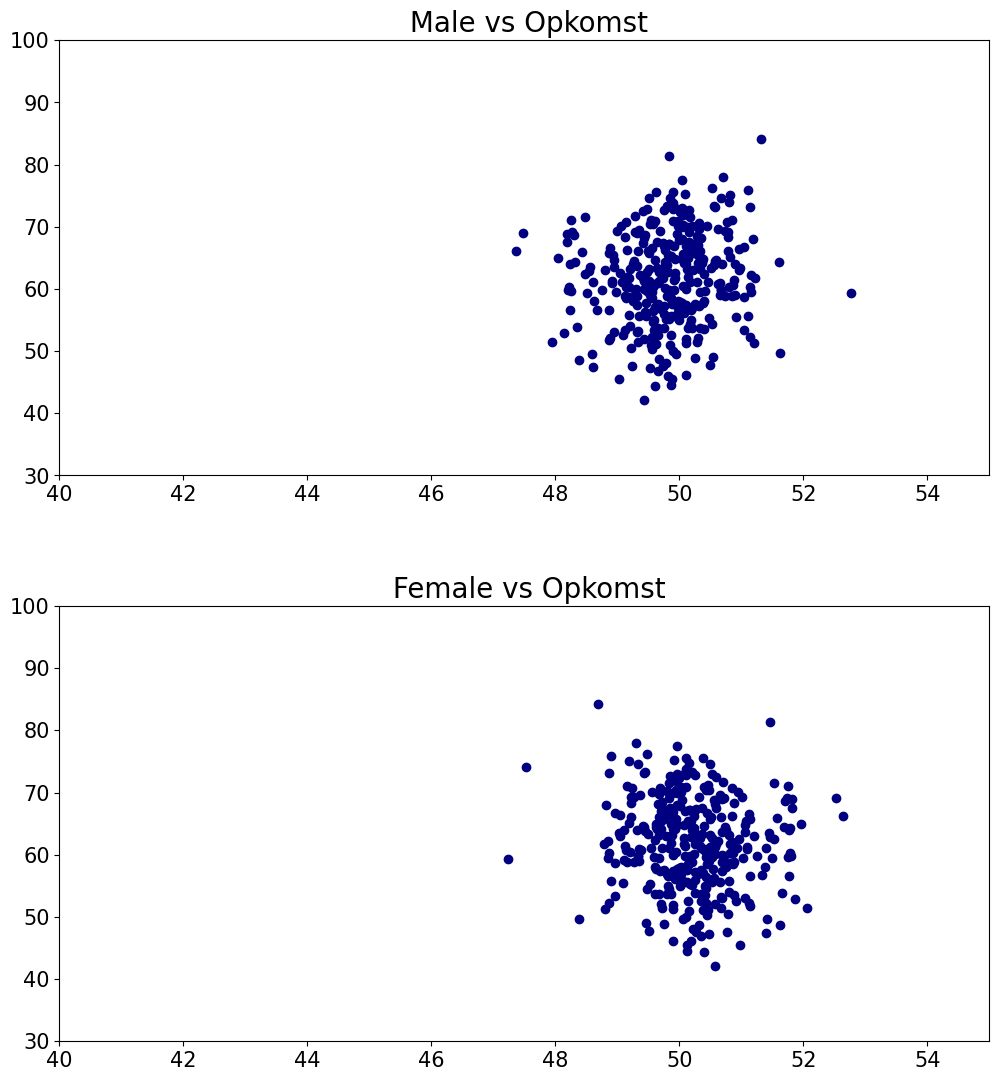

In [313]:
KWB_data_gm_2021_select_gender                = KWB_data_2021_gm[['a_man','a_vrouw','a_inw','GM2023']]
KWB_data_gm_2021_select_gender                = KWB_data_gm_2021_select_gender.groupby('GM2023').sum().reset_index()
KWB_data_gm_2021_select_gender['male_per']    = KWB_data_gm_2021_select_gender['a_man']*100/(KWB_data_gm_2021_select_gender['a_inw'])
KWB_data_gm_2021_select_gender['Female_per']  = KWB_data_gm_2021_select_gender['a_vrouw']*100/(KWB_data_gm_2021_select_gender['a_inw'])

turn_up_vs_gender = pd.merge(turn_up_data,KWB_data_gm_2021_select_gender,left_on='GemeenteNaam',right_on='GM2023')

print("Correlation with Male is {}".format((turn_up_vs_gender['male_per']).corr(turn_up_vs_gender['Fraction_turn_up'])))
print("Correlation with female is {}".format((turn_up_vs_gender['Female_per']).corr(turn_up_vs_gender['Fraction_turn_up'])))

plt.subplot(2,1,1)
plt.gcf().set_size_inches(12, 13)
plt.subplots_adjust(hspace = 0.3)
plt.scatter(turn_up_vs_gender['male_per'],turn_up_vs_gender['Fraction_turn_up'],color = ['navy'])
plt.title(" Male vs Opkomst",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(30, 100)
plt.xlim(40, 55)
plt.subplot(2,1,2)
plt.scatter(turn_up_vs_gender['Female_per'],turn_up_vs_gender['Fraction_turn_up'],color = ['navy'])
plt.title(" Female vs Opkomst",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(30, 100)
plt.xlim(40, 55)


## House Price Vs Turn up

In [314]:
house_price = KWB_data_2022_gm[['g_wozbag','gwb_code','a_woning']]

In [315]:
mapping_to_22_23 = pd.read_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Data//Gemeente_data//GemeenteMapped2022//_2022.xlsx")

# mapping house prices to 2023 level gemeente 

gm_23 = []
for i in range(len(KWB_data_2022_gm)):
    tempgm = mapping_to_22_23[mapping_to_22_23['GemeentecodeGM']==house_price['gwb_code'][i]]
    tempgm.reset_index(drop=True, inplace= True)
    gm_23.append(tempgm['_2022'][0]) 
                              
house_price['GM2023'] = gm_23  

In [316]:
# Combining hosue price of the gemmente merged in 2023

house_price_selection = house_price[['GM2023','a_woning','g_wozbag']]

house_price_selection['total_price'] = house_price_selection['a_woning']*house_price_selection['g_wozbag']

house_price_selection                = house_price_selection.groupby('GM2023').sum().reset_index()
house_price_selection['g_wozbag']    = house_price_selection['total_price']/house_price_selection['a_woning']
print(house_price_selection.shape)

# Merge

turn_up_vs_houseprice = pd.merge(turn_up_data,house_price_selection,left_on='GemeenteNaam',right_on='GM2023')

turn_up_vs_houseprice.to_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Files//HousePriceVsTurnup.xlsx")

(342, 4)


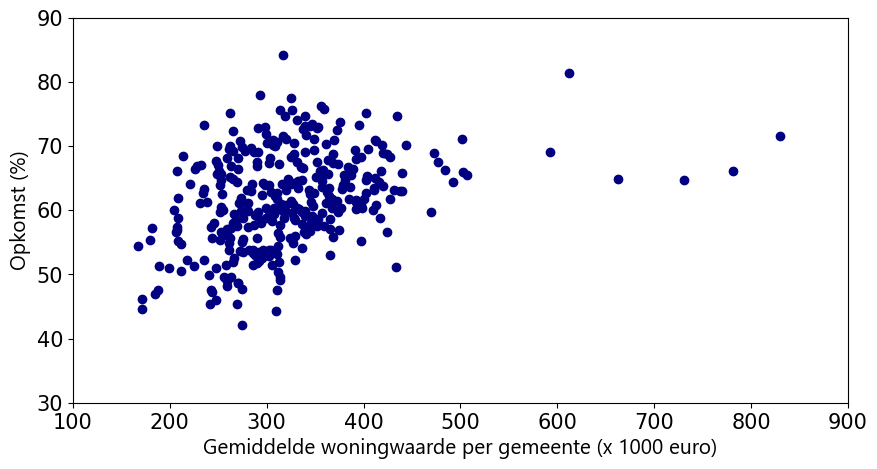

In [317]:
plt.rcParams["figure.figsize"] = [10,5]
plt.scatter(turn_up_vs_houseprice['g_wozbag'],turn_up_vs_houseprice['Fraction_turn_up'],color = ['navy'])
plt.ylim(30, 90)
plt.xlim(100, 900)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Gemiddelde woningwaarde per gemeente (x 1000 euro)',fontsize=15,fontname="Segoe UI")
plt.ylabel('Opkomst (%)',fontsize=15,fontname="Segoe UI")

plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//HousePriceVsTurnup.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//HousePriceVsTurnup.png", format='png', dpi=500,bbox_inches = 'tight')
plt.show()

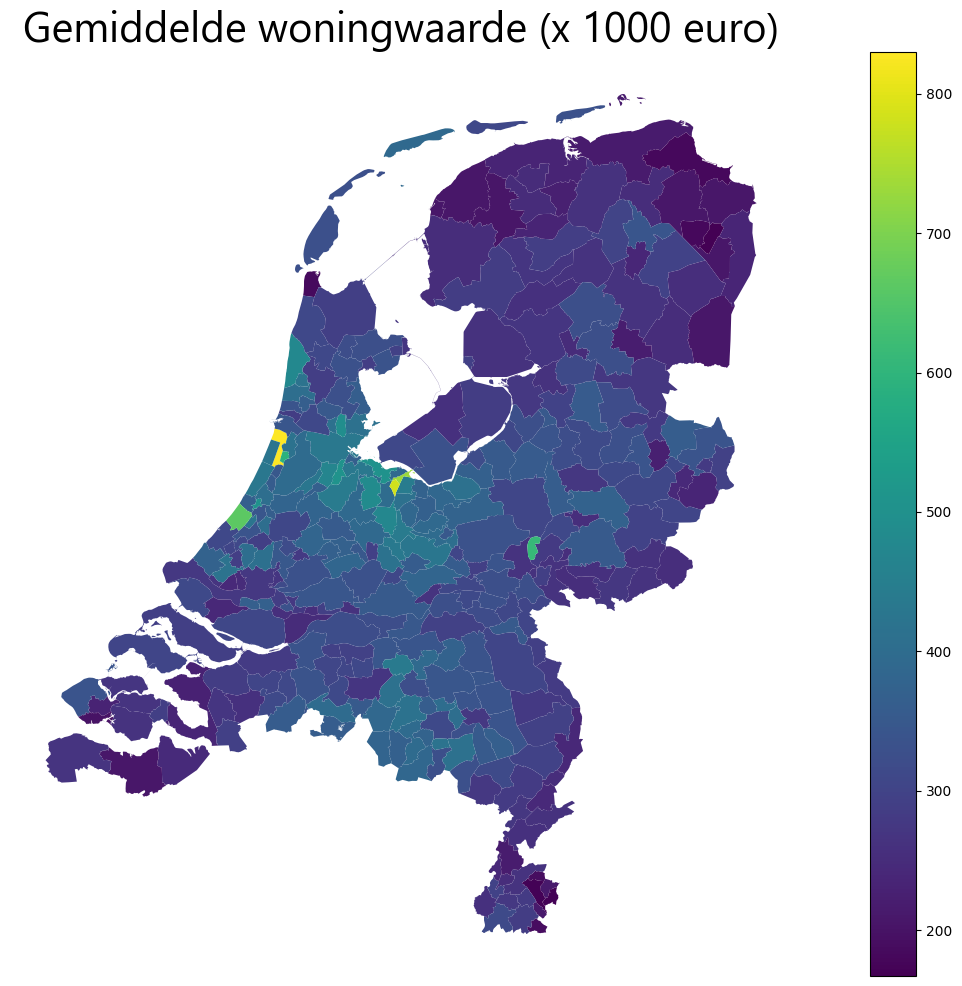

In [58]:
#house_price = pd.merge(gemeentegrenzen,house_price_selection,left_on= 'naam', right_on='GM2023')
house_price = pd.merge(gemeentegrenzen,house_price_selection,left_on= 'statnaam', right_on='GM2023')
p = house_price.plot(column= 'g_wozbag', figsize = (20,12), legend = True, markersize = 12, cmap = 'viridis')
fig = p.figure
cb_ax = fig.axes[0]
cb_ax.tick_params(labelsize=25)
#p.set_title('Mediane afstand tot stemlokalen', fontsize = 30,color = "black",fontname="Segoe UI")
p.set_title('Gemiddelde woningwaarde (x 1000 euro)', fontsize = 30,color = "black",fontname="Segoe UI")
p.axis('off')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//map_house_price_geo.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//map_house_price_geo.png", format='png', dpi=500,bbox_inches = 'tight')

# Polling station distribution vs Gemeente income

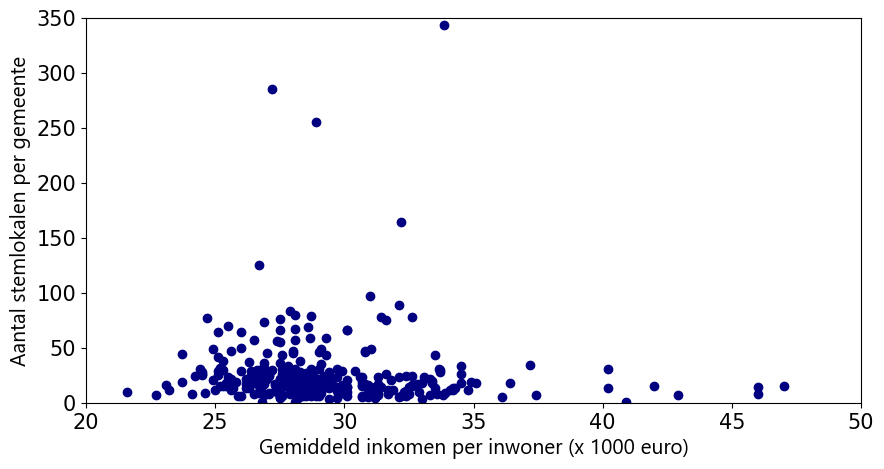

In [282]:
change_names = { 'Beek (L.)':'Beek', 'Hengelo (O.)':'Hengelo','Laren (NH.)':'Laren','Middelburg (Z.)':'Middelburg',
                'Rijswijk (ZH.)':'Rijswijk','Stein (L.)':'Stein'   
              }


gemeente_selection = wims_data_all[['Gemeente','CBS gemeentecode']]

gemeente_selection = gemeente_selection.groupby(['Gemeente']).count().reset_index()

#gemeente_selection['Gemeente'] = gemeente_selection['Gemeente'].map(change_names)

gemeente_selection = gemeente_selection.replace({"Gemeente": change_names})

income_selection             = KWB_data_2021_gm[['GM2023','g_ink_pi']]
income_selection['g_ink_pi'] = income_selection['g_ink_pi'].replace(',', '.', regex = True)
income_selection['g_ink_pi'] = income_selection['g_ink_pi'].astype(float)
income_selection = income_selection.groupby('GM2023').mean().reset_index()

PSvsIncome = pd.merge(income_selection,gemeente_selection, left_on= 'GM2023', right_on ='Gemeente')

plt.rcParams["figure.figsize"] = [10,5]

plt.scatter(PSvsIncome['g_ink_pi'],PSvsIncome['CBS gemeentecode'],color = ['navy'])
plt.ylim(0, 350)
plt.xlim(20, 50)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Gemiddeld inkomen per inwoner (x 1000 euro)',fontsize=15,fontname="Segoe UI")
plt.ylabel('Aantal stemlokalen per gemeente',fontsize=15,fontname="Segoe UI")
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//GM_PollingstationVsIncome.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//Gm_PollingstationVsIncome.png", format='png', dpi=500,bbox_inches = 'tight')


C:\Users\CentERdata\AppData\Local\Temp\ipykernel_15728\222387709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc['nn'] = cc['CBS gemeentecode']/bb['a_inw']


(array([0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009,
        0.001 , 0.0011, 0.0012]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

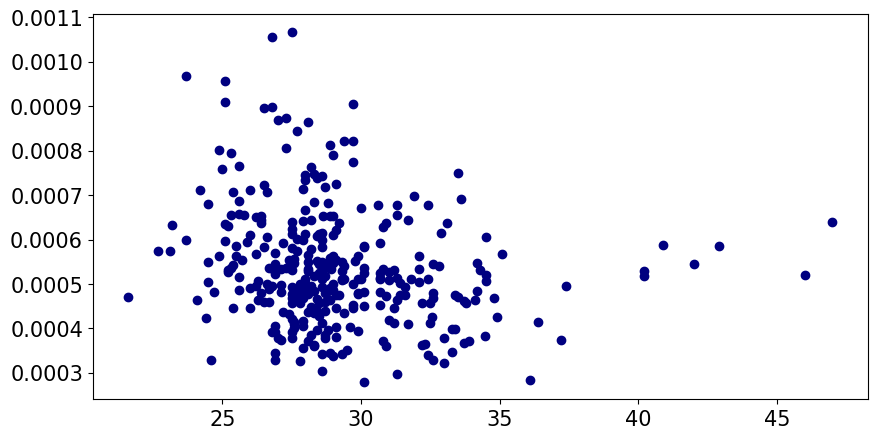

In [120]:
# Polling station normalized to population density

aa = wims_data_all[['Gemeente','CBS gemeentecode']]
aa = aa.groupby(['Gemeente']).count().reset_index()
bb = pd.merge(KWB_data_gm_2021_select,aa, left_on= 'GM2023', right_on ='Gemeente')
cc = bb[['g_ink_pi','CBS gemeentecode']] 
cc['nn'] = cc['CBS gemeentecode']/bb['a_inw']

#plt.scatter(cc['g_ink_pi'],cc['CBS gemeentecode'],color = ['navy'])
plt.scatter(cc['g_ink_pi'],cc['nn'],color = ['navy'])
#plt.ylim(0, 0.001)
#plt.xlim(20, 50)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Polling station distribution vs House Price

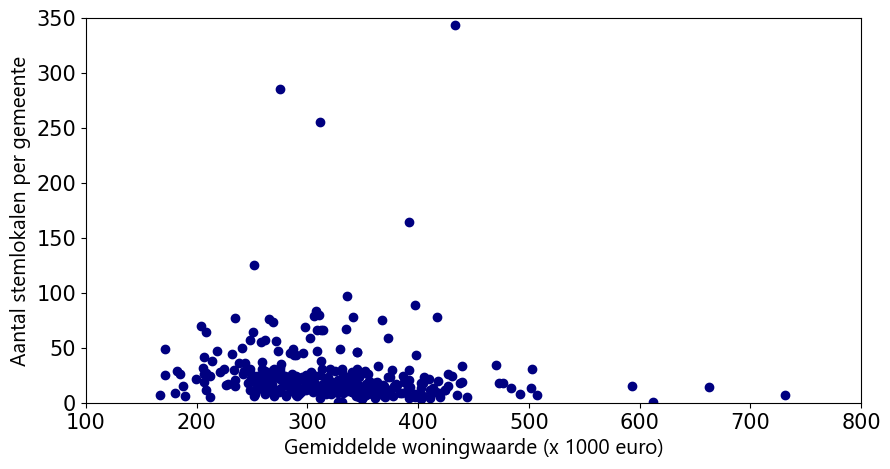

In [284]:
gemeente_selection = wims_data_all[['Gemeente','CBS gemeentecode']]

gemeente_selection = gemeente_selection.groupby(['Gemeente']).count().reset_index()

houseprice_selection             = house_price[['GM2023','g_wozbag']]
houseprice_selection             = houseprice_selection.replace({"GM2023": change_names})
houseprice_selection['g_wozbag'] = houseprice_selection['g_wozbag'].replace(',', '.', regex = True)
houseprice_selection['g_wozbag'] = houseprice_selection['g_wozbag'].astype(float)
houseprice_selection             = houseprice_selection.groupby('GM2023').mean().reset_index()

housepriceVspollinstation = pd.merge(houseprice_selection,gemeente_selection, left_on= 'GM2023', right_on ='Gemeente')

plt.rcParams["figure.figsize"] = [10,5]

plt.scatter(housepriceVspollinstation['g_wozbag'],housepriceVspollinstation['CBS gemeentecode'],color = ['navy'])
plt.ylim(0, 350)
plt.xlim(100, 800)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Gemiddelde woningwaarde (x 1000 euro)',fontsize=15,fontname="Segoe UI")
plt.ylabel('Aantal stemlokalen per gemeente',fontsize=15,fontname="Segoe UI")
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//GM_PollingstationVsHousePrice.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//GM_PollingstationVsHousePrice.png", format='png', dpi=500,bbox_inches = 'tight')
